# 1. Read files

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [474]:
df_train = pd.read_csv('train.csv', index_col = 0)
df_test = pd.read_csv('test.csv',index_col = 0)

In [3]:
y = df_train['SalePrice']
X = df_train.drop(['SalePrice'], axis = 1)
X_test = df_test

In [4]:
# introduct 'set' columns
df_combined = pd.concat([X.assign(set = 'train'), X_test.assign(set = 'test')], axis = 0)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

# 2. Simple explanatory data analysis

### 2.1 comparison of nulls in train/test

In [5]:
pd.concat([X.isnull().sum().rename('null in train'), X_test.isnull().sum().rename('null in test')], axis = 1)\
        .sort_values(['null in train', 'null in test'], ascending = False)\
        .style.background_gradient(vmin = 0, vmax = max([X.shape[0], X_test.shape[0]]))
        

,null in train,null in test
PoolQC,1453,1456
MiscFeature,1406,1408
Alley,1369,1352
Fence,1179,1169
FireplaceQu,690,730
LotFrontage,259,227
GarageYrBlt,81,78
GarageFinish,81,78
GarageQual,81,78
GarageCond,81,78


### 2.2 heatmap to visualize null values in trian/test

In [6]:
X.isnull().T.head()

Id,1,2,3,4,5,6,7,8,9,10,...,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
MSSubClass,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MSZoning,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
LotFrontage,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
LotArea,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Street,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


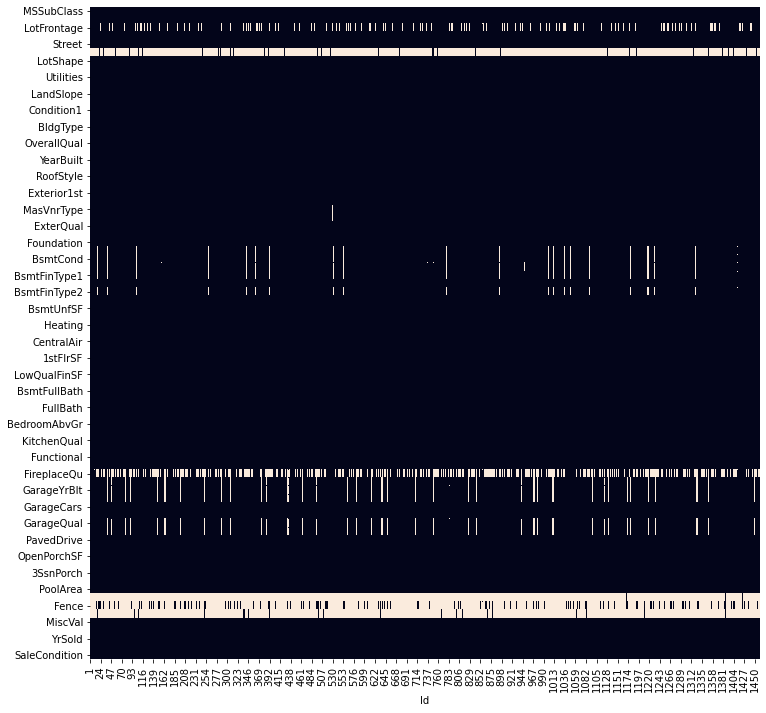

In [7]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(X.isnull().T, ax = ax, cbar = False );

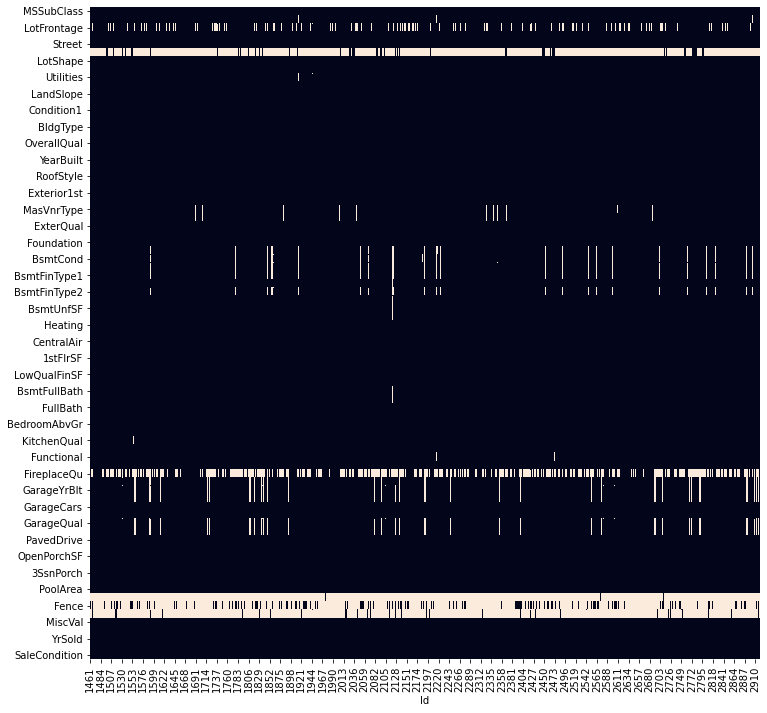

In [8]:
fig, ax = plt.subplots(figsize = (12,12))
sns.heatmap(X_test.isnull().T, ax = ax, cbar = False );

### 2.3 Visualize numeric and object features

In [9]:
plt.style.use('ggplot')

In [10]:
col_num = X.select_dtypes(exclude = ['object']).columns
col_obj = X.select_dtypes(include = ['object']).columns

In [11]:
len(col_num), len(col_obj)

(36, 43)

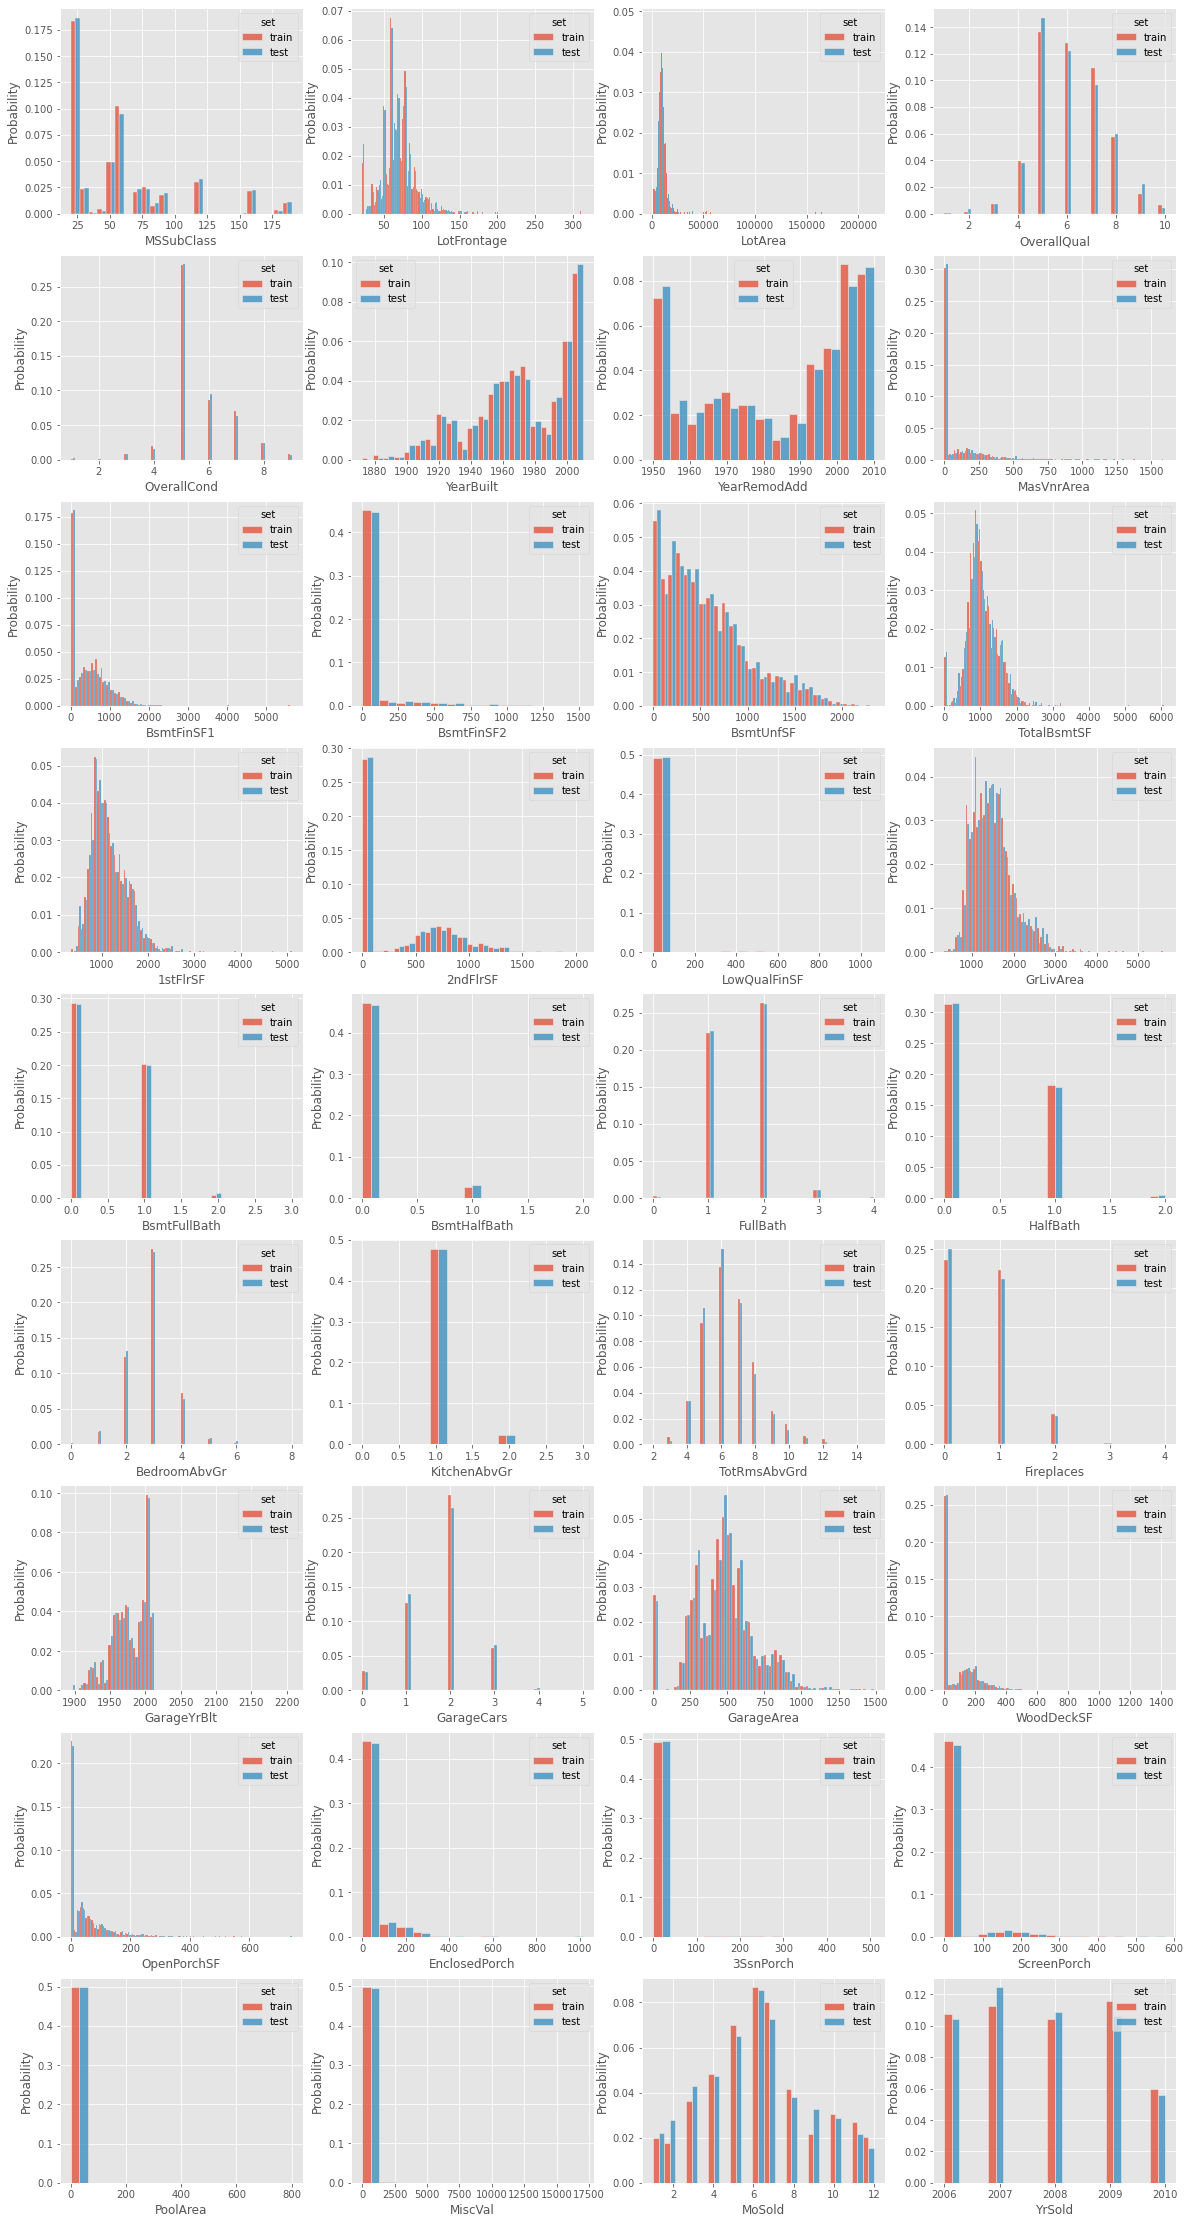

In [12]:
fig, ax = plt.subplots(nrows = 9, ncols = 4, figsize = (20, 40))
for col, ax in zip(col_num, ax.flat):
    sns.histplot(data = df_combined, x = col, hue = 'set', stat = 'probability', ax = ax, multiple = 'dodge', common_norm = 'False')

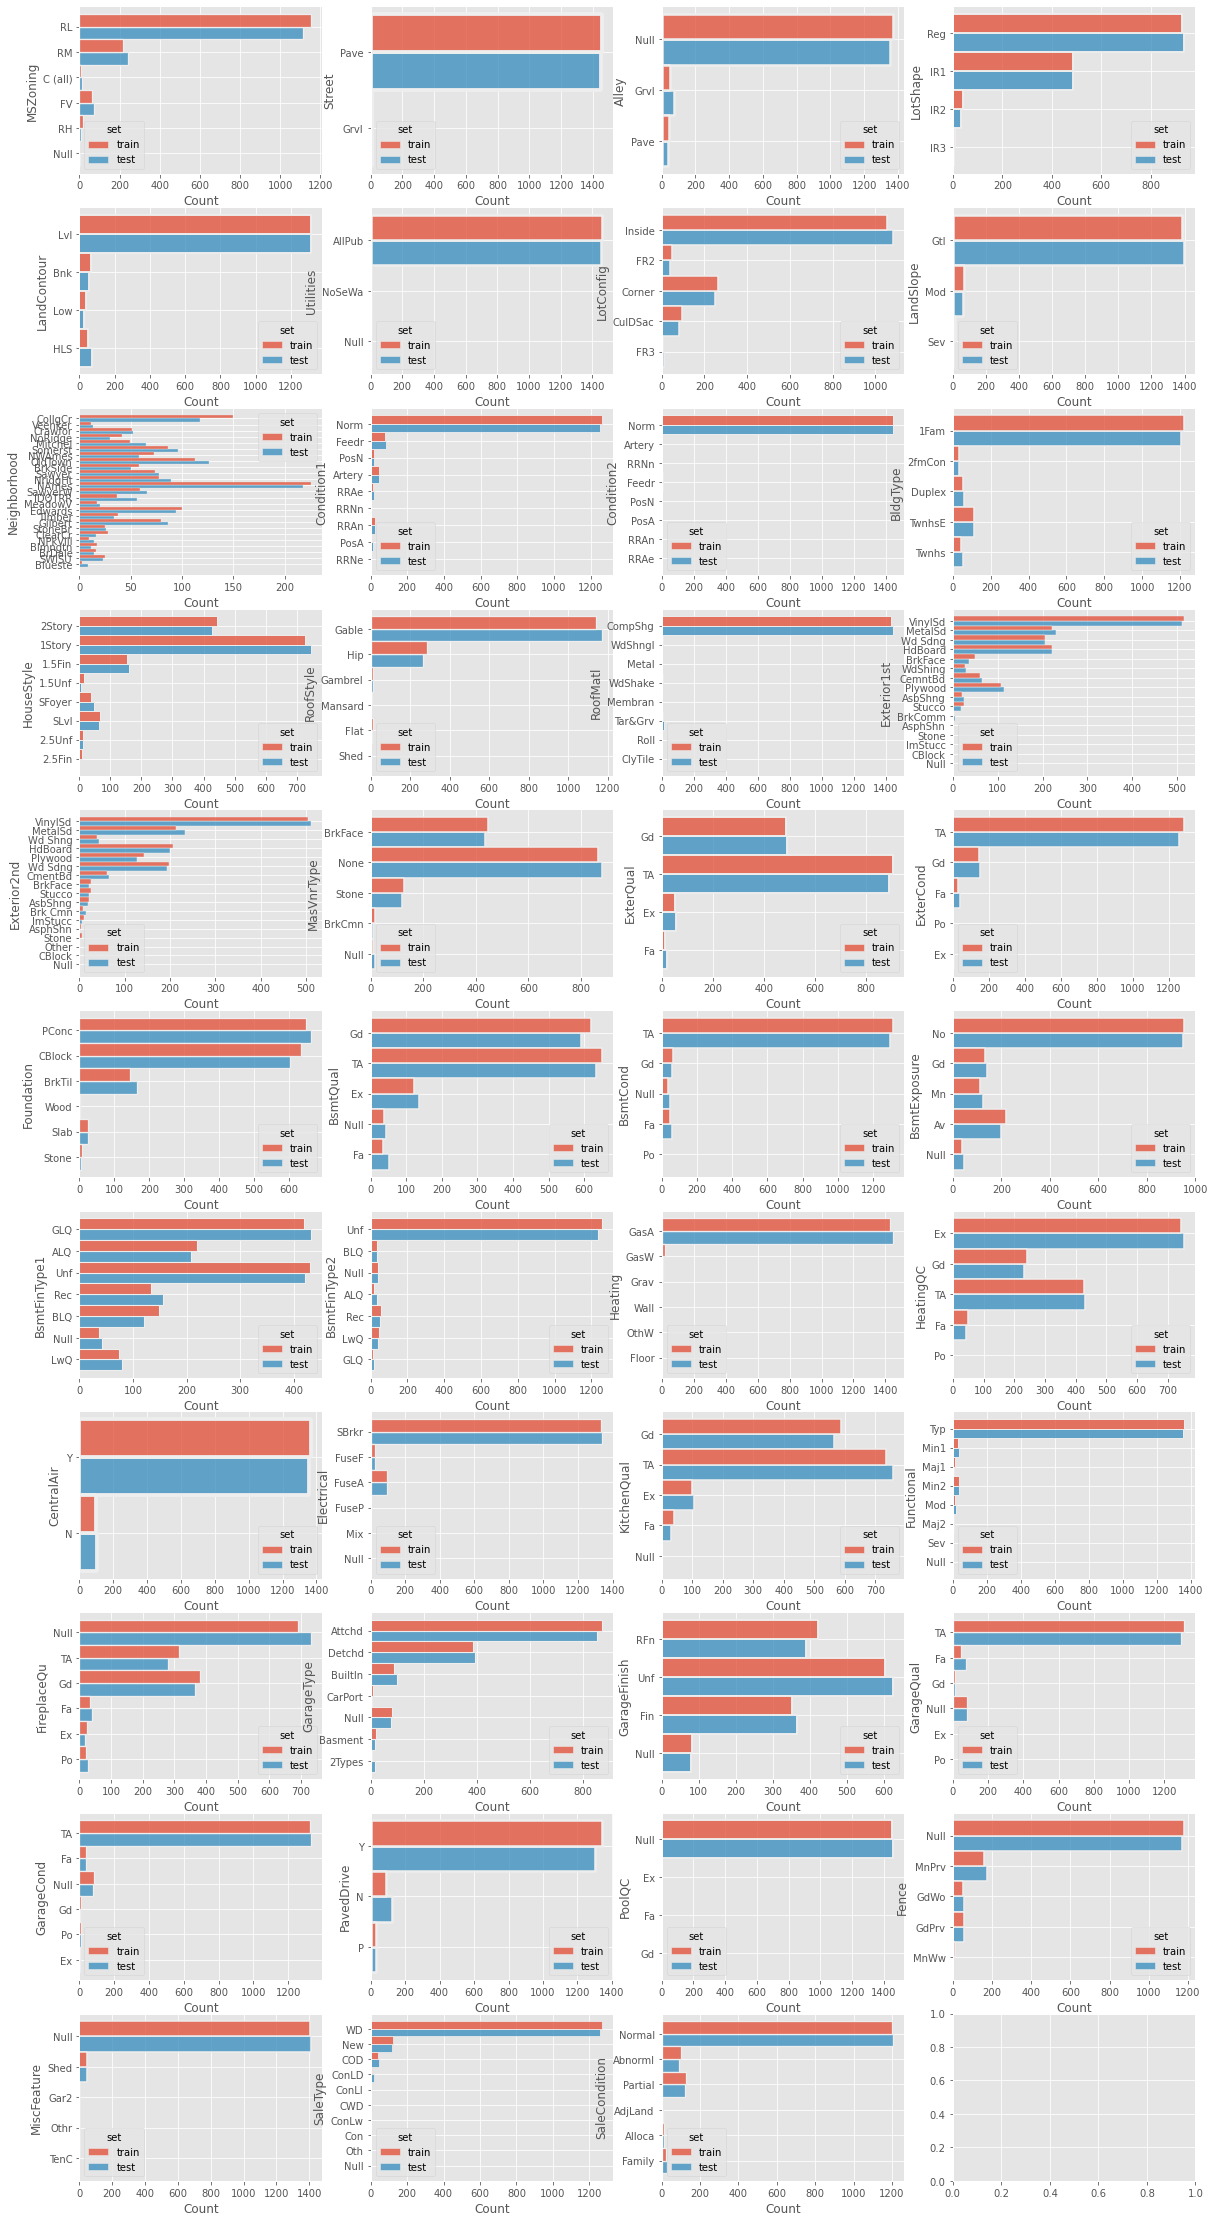

In [13]:
# missing have to be filled for plotting
fig, ax = plt.subplots(nrows = 11, ncols = 4, figsize = (20, 40))
for col, ax in zip(col_obj, ax.flat):
    sns.histplot(data = df_combined, y = df_combined[col].fillna('Null'),
                 hue = 'set',  
                 ax = ax, 
                 multiple = 'dodge', 
                 common_norm = 'False')

# 3. Simple feature engineering

### 3.1 Ordinal categorical features
* 'NA' in many features have been read as Null during reading, so first need to find those features and fill missing with 'Null'
* Mapping each ordinal feature to corresponding values
* convert type from 'object' to 'categoty'

In [14]:
# Ordinal categorical features
dict_string2value = {
    'Street': {'Pave': 2, 'Grvl': 1},
    'Alley': {'Pave': 2, 'Grvl': 1, 'NULL':0}, # np.NaN: 0
    'LotShape': {'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
    'LandContour': {'Lvl':3, 'Bnk':2, 'HLS':1, 'Low':0},
    'Utilities': {"AllPub": 4, "NoSewr ": 3, "NoSeWa":2, "ELO": 1, 'NULL':0}, # np.NaN: 0
    'LandSlope': {"Gtl": 3, "Mod": 2, "Sev": 1},
    "ExterQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1},
    "ExterCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1}, 
    "BsmtQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "BsmtCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "BsmtExposure": {"Gd":4, "Av":3, "Mn":2, "No":1, 'NULL':0}, # np.NaN: 0
    "BsmtFinType1": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, 'NULL':0}, # np.NaN: 0
    "BsmtFinType2": {"GLQ":6, "ALQ":5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, 'NULL':0}, # np.NaN: 0
    "HeatingQC": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1},
    "CentralAir": {"Y":1, "N":0},
    "Electrical": {"SBrkr":5, "FuseA":4, "FuseF":3, "FuseP":2, "Mix":1, 'NULL':0}, # np.NaN: 0
    "KitchenQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "Functional": {"Typ":8, "Min1":7, "Min2":6, "Mod":5, "Maj1":4, "Maj2":3, "Sev":2, "Sal":1, 'NULL':0}, # np.NaN: 0
    "FireplaceQu": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "GarageFinish": {"Fin":3, "RFn":2, "Unf":1, 'NULL':0}, # np.NaN: 0
    "GarageQual": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "GarageCond": {"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1, 'NULL':0}, # np.NaN: 0
    "PavedDrive": {"Y":2, "P":1, "N":0},
    "PoolQC":  {"Ex":4, "Gd":3, "TA":2, "Fa":1, 'NULL':0}, # np.NaN: 0
}

# ordinal features with 'NA'
dic_NA = {
    "Alley",
    "Utilities",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Electrical",
    "KitchenQual",
    "Functional",
    "FireplaceQu",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "PoolQC",
}

In [15]:
def fill_NA(X):
    X = X.copy()
    for col in dic_NA:
        X[col] = X[col].fillna('NULL')
    return X.replace(dict_string2value)

In [16]:
def to_ordered_categories(X):
    X = X.copy()
    for k, v in dict_string2value.items():
        categories = list(v.values())
        X[k] = pd.Categorical(X[k], categories=categories, ordered=True)
    return X

In [17]:
df_combined_1 = fill_NA(df_combined)
X_1 = fill_NA(X)
X_test_1= fill_NA(X_test)

In [18]:
# df_combined_2 = to_ordered_categories(df_combined_1)
# X_2 = to_ordered_categories(X_1)
# X_test_2 = to_ordered_categories(X_test)

In [19]:
melt_df = X_1[dict_string2value].assign(SalePrice = y).melt(id_vars=['SalePrice'], var_name = 'feature')
melt_df

,SalePrice,feature,value
0,208500,Street,2
1,181500,Street,2
2,223500,Street,2
3,140000,Street,2
4,250000,Street,2
...,...,...,...
35035,175000,PoolQC,0
35036,210000,PoolQC,0
35037,266500,PoolQC,0
35038,142125,PoolQC,0


C:\Anacoda\lib\site-packages\seaborn\categorical.py:3803: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


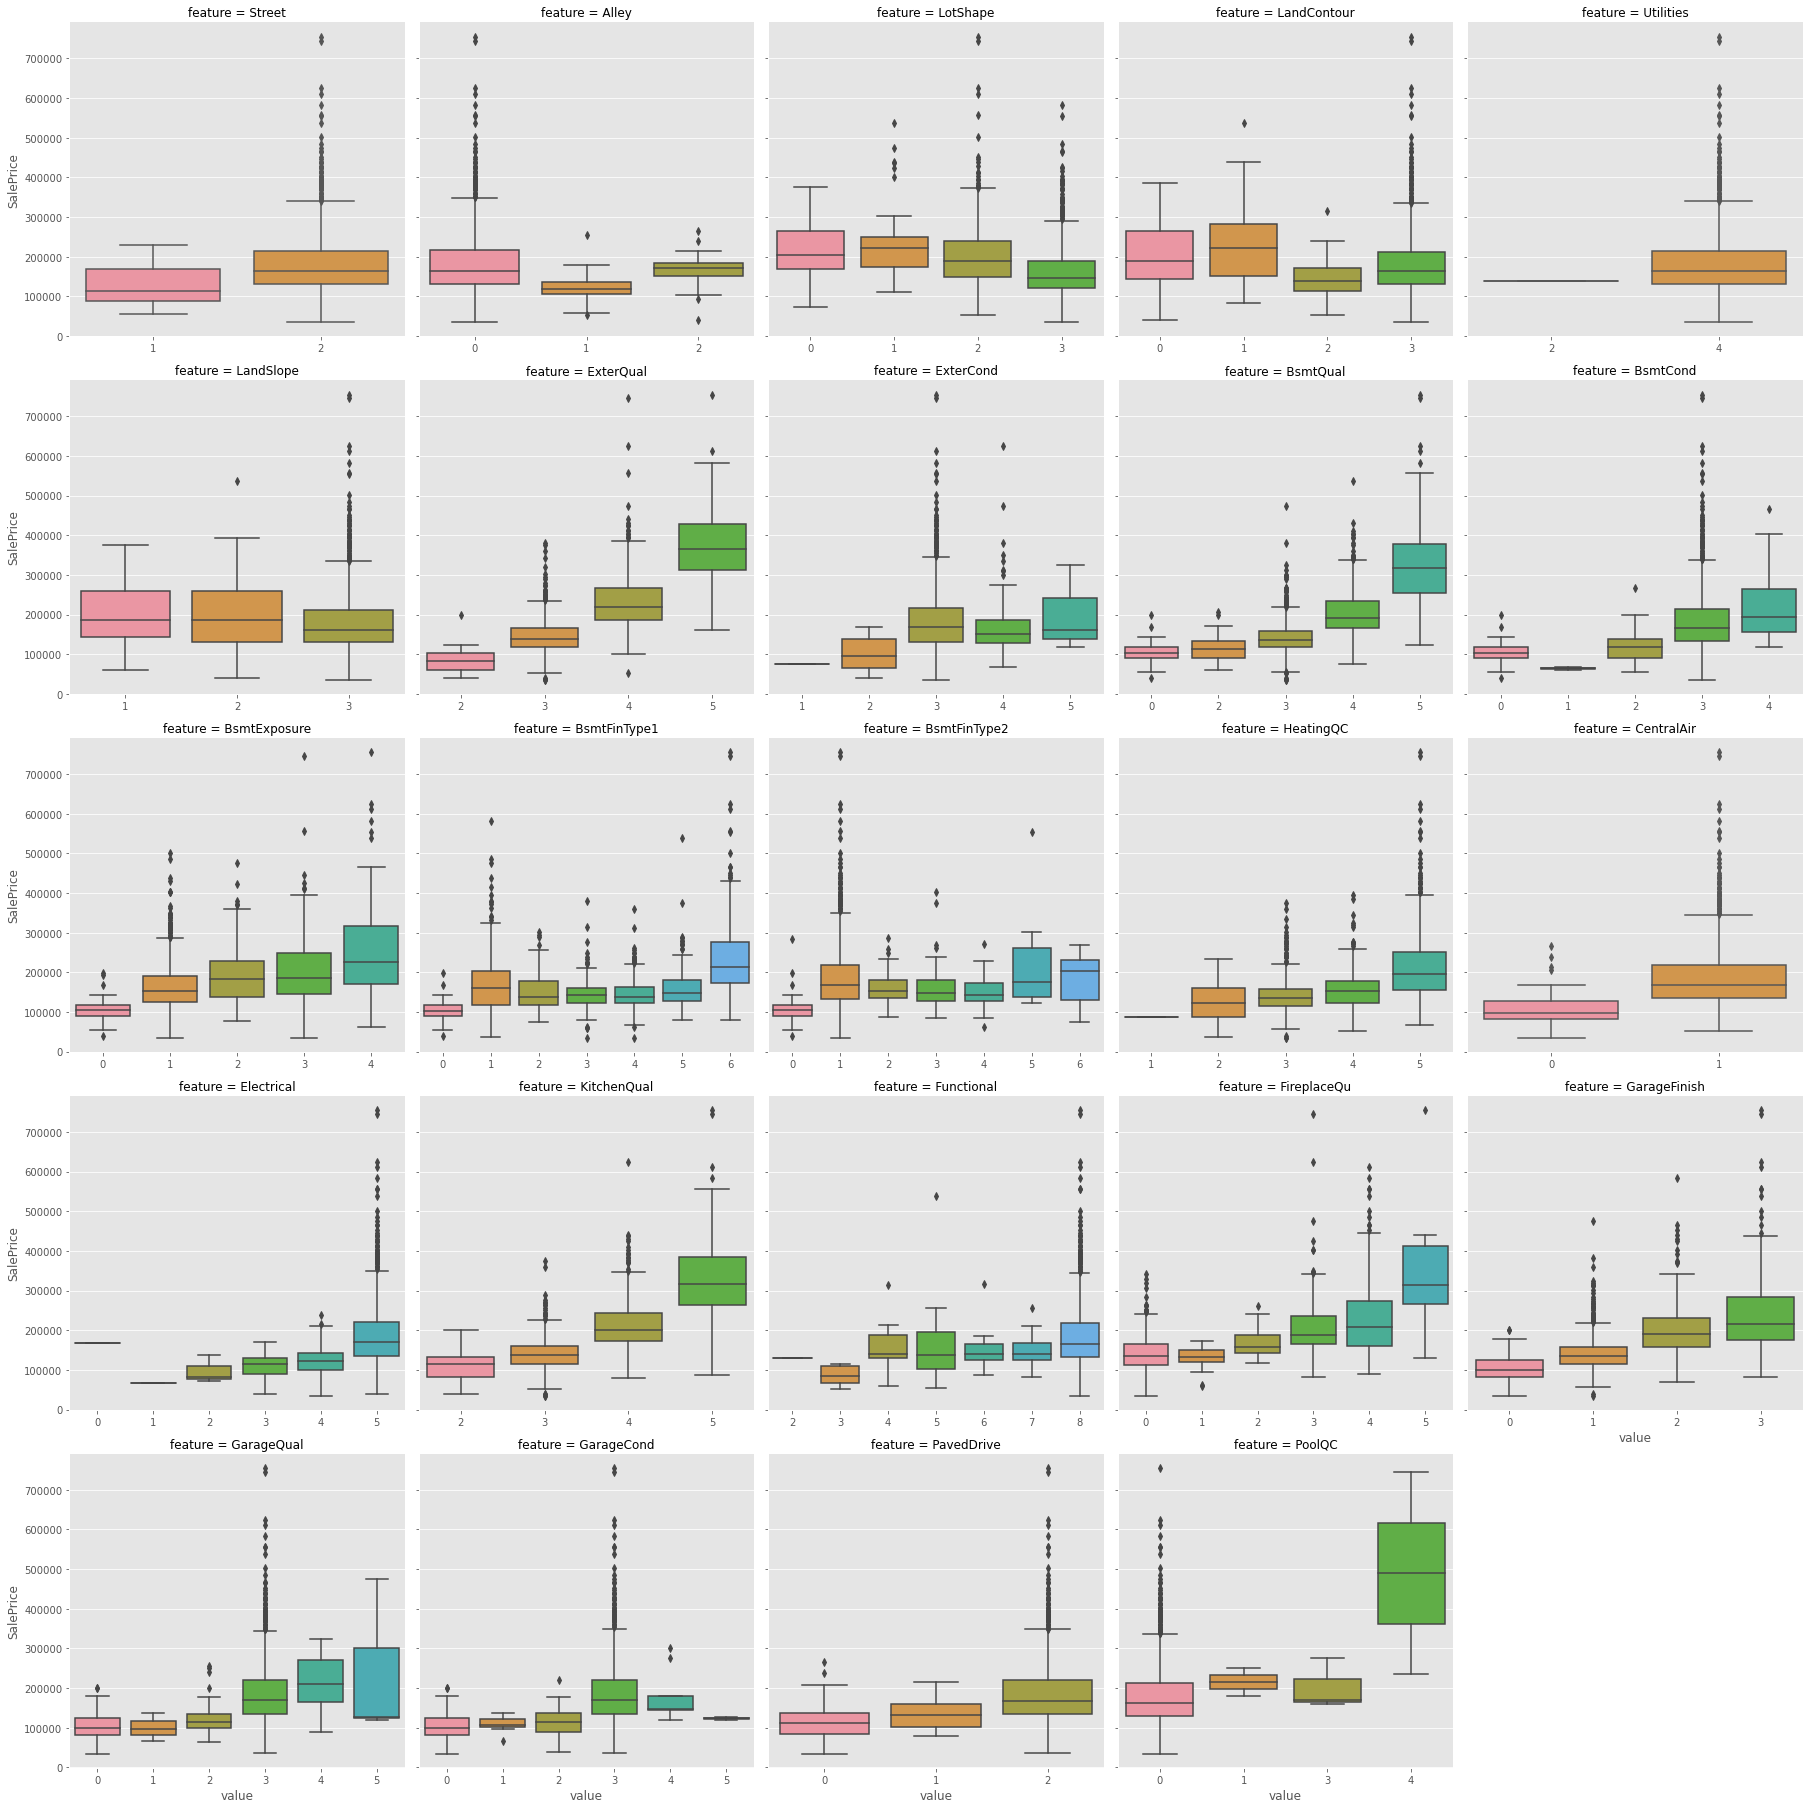

In [20]:
# Viualize 'SalePrcie' is positively correlated with categorical feature values.
sns.catplot(data = melt_df, x = 'value', y = 'SalePrice', col = 'feature', col_wrap=5, kind = 'box', sharex = False, height = 5);

In [21]:
# pairwise correlations between ordinal feature and saleprice
X_1[dict_string2value].corrwith(y).rename('pair_correlation')\
                    .sort_values(ascending = False).to_frame()\
                    .style.bar(vmin=-1, align='zero', vmax=1)

,pair_correlation
ExterQual,0.682639
KitchenQual,0.659600
BsmtQual,0.585207
GarageFinish,0.549247
FireplaceQu,0.520438
HeatingQC,0.427649
BsmtExposure,0.374696
BsmtFinType1,0.304908
GarageQual,0.273839
GarageCond,0.263191


* Not all features are positively correlated with price

### 3.2 Dealing with other missings

In [22]:
col_na = df_combined_1.columns[(df_combined_1.isna().sum() > 0)].sort_values().tolist()
col_na

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'GarageArea',
 'GarageCars',
 'GarageType',
 'GarageYrBlt',
 'LotFrontage',
 'MSZoning',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'SaleType',
 'TotalBsmtSF']

In [23]:
# visualize these NA values
df_combined_1[col_na].nunique().sort_values(ascending = False)\
                     .to_frame(name = 'number of unique values in features with NA')\
                     .style.bar()

,number of unique values in features with NA
BsmtUnfSF,1135
TotalBsmtSF,1058
BsmtFinSF1,991
GarageArea,603
MasVnrArea,444
BsmtFinSF2,272
LotFrontage,128
GarageYrBlt,103
Exterior2nd,16
Exterior1st,15


### 3.2.1 missing in object feature

In [24]:
col_na_obj = df_combined_1[col_na].nunique().loc[lambda x: x<20].index
col_na_obj

Index(['BsmtFullBath', 'BsmtHalfBath', 'Exterior1st', 'Exterior2nd', 'Fence',
       'GarageCars', 'GarageType', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'SaleType'],
      dtype='object')

In [25]:
# Further compare respective NA in train and test

columns = pd.DataFrame([[c, X_1[c].unique(), [x for x in X_test_1[c].unique() if x not in X_1[c].unique() ] ] for c in col_na_obj], 
            columns = ['feature with NA(<=20)', 'unique values in train', 'unique values in test']).set_index('feature with NA(<=20)')
pd.concat([columns,  X_1[col_na_obj].isna().sum().rename('NA train'), X_test_1[col_na_obj].isna().sum().rename('NA test')],axis = 1)\
        .style

,unique values in train,unique values in test,NA train,NA test
feature with NA(<=20),,,,
BsmtFullBath,[1 0 2 3],[nan],0,2
BsmtHalfBath,[0 1 2],[nan],0,2
Exterior1st,['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd' 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc' 'CBlock'],[nan],0,1
Exterior2nd,['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd' 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone' 'Other' 'CBlock'],[nan],0,1
Fence,[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'],[nan],1179,1169
GarageCars,[2 3 1 0 4],"[5.0, nan]",0,1
GarageType,['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types'],[nan],81,76
MSZoning,['RL' 'RM' 'C (all)' 'FV' 'RH'],[nan],0,4
MasVnrType,['BrkFace' 'None' 'Stone' 'BrkCmn' nan],[nan],8,16


* 'Wd Shng'should be 'WdShing'
* 'Brk Cmn' should be 'BrkComm'
* 'CmentBd' should be 'CemntBd'
* For low missings, fill with 0 or 'other'

In [26]:
dic_NA_obj = {
    'BsmtFullBath': 0,
    'BsmtHalfBath': 0,
    'Exterior1st': 'Other',
    'Exterior2nd': 'Other',
    'Fence': 'NA',
    'GarageCars':0 ,
    'GarageType': 'NA' ,
    'MSZoning': 'Other' ,
    'MasVnrType': 'None',
    'MiscFeature': 'NA' ,
    'SaleType': 'Oth'}

def fill_NA_object(X):
    X = X.fillna(dic_NA_obj)
    return X

In [27]:
X_2 = fill_NA_object(X_1)
X_test_2 = fill_NA_object(X_test_1)
df_combined_2 = fill_NA_object(df_combined_1)

### 3.2.2 missing in numeric feature

In [28]:
col_na_num = df_combined_2[col_na].nunique().loc[lambda x: x>=20].index
col_na_num

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt',
       'LotFrontage', 'MasVnrArea', 'TotalBsmtSF'],
      dtype='object')

In [29]:
df_combined_2[col_na_num].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,GarageArea,GarageYrBlt,LotFrontage,MasVnrArea,TotalBsmtSF
count,2918.000000,2918.000000,2918.000000,2918.000000,2760.000000,2433.000000,2896.000000,2918.000000
mean,441.423235,49.582248,560.772104,472.874572,1978.113406,69.305795,102.201312,1051.777587
std,455.610826,169.205611,439.543659,215.394815,25.574285,23.344905,179.334253,440.766258
min,0.000000,0.000000,0.000000,0.000000,1895.000000,21.000000,0.000000,0.000000
25%,0.000000,0.000000,220.000000,320.000000,1960.000000,59.000000,0.000000,793.000000
50%,368.500000,0.000000,467.000000,480.000000,1979.000000,68.000000,0.000000,989.500000
75%,733.000000,0.000000,805.500000,576.000000,2002.000000,80.000000,164.000000,1302.000000
max,5644.000000,1526.000000,2336.000000,1488.000000,2207.000000,313.000000,1600.000000,6110.000000


* max('GarageYrBlt') is wrong

In [30]:
# seperately visualize numeric missing in trian and test
display(X_2.loc[:, lambda x: x.isnull().sum() > 0].describe())
display(X_test_2.loc[:, lambda x: x.isnull().sum() > 0].describe())

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,GarageYrBlt,GarageArea
count,1232.000000,1444.000000,1458.000000,1458.000000,1458.000000,1458.000000,1381.000000,1458.000000
mean,68.580357,100.709141,439.203704,52.619342,554.294925,1046.117970,1977.721217,472.768861
std,22.376841,177.625900,455.268042,176.753926,437.260486,442.898624,26.431175,217.048611
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000
25%,58.000000,0.000000,0.000000,0.000000,219.250000,784.000000,1959.000000,318.000000
50%,67.000000,0.000000,350.500000,0.000000,460.000000,988.000000,1979.000000,480.000000
75%,80.000000,164.000000,753.500000,0.000000,797.750000,1305.000000,2002.000000,576.000000
max,200.000000,1290.000000,4010.000000,1526.000000,2140.000000,5095.000000,2207.000000,1488.000000


In [31]:
pd.concat([X_2.isnull().sum().rename('num NA in train'), X_test_2.isnull().sum().rename('num NA in test')], axis = 1)\
        .sort_values(['num NA in train', 'num NA in test'], ascending = False)\
        .style

,num NA in train,num NA in test
LotFrontage,259,227
GarageYrBlt,81,78
MasVnrArea,8,15
BsmtFinSF1,0,1
BsmtFinSF2,0,1
BsmtUnfSF,0,1
TotalBsmtSF,0,1
GarageArea,0,1
MSSubClass,0,0
MSZoning,0,0


* low num NA can be directly filled with 0

In [32]:
dic_NA_num = {
    'MasVnrArea': 0,
    'BsmtFinSF1': 0,
    'BsmtFinSF2': 0,
    'BsmtUnfSF': 0,
    'TotalBsmtSF': 0,
    'GarageArea': 0}

def fill_NA_num(X):
    return X.fillna(dic_NA_num)

In [33]:
X_3 = fill_NA_num(X_2)
X_test_3 = fill_NA_num(X_test_2)
df_combined_3 = fill_NA_num(df_combined_2)

In [34]:
display(X_3.loc[:, lambda x: x.isnull().sum() > 0].describe())
display(X_test_3.loc[:, lambda x: x.isnull().sum() > 0].describe())

,LotFrontage,GarageYrBlt
count,1201.000000,1379.000000
mean,70.049958,1978.506164
std,24.284752,24.689725
min,21.000000,1900.000000
25%,59.000000,1961.000000
50%,69.000000,1980.000000
75%,80.000000,2002.000000
max,313.000000,2010.000000


,LotFrontage,GarageYrBlt
count,1232.000000,1381.000000
mean,68.580357,1977.721217
std,22.376841,26.431175
min,21.000000,1895.000000
25%,58.000000,1959.000000
50%,67.000000,1979.000000
75%,80.000000,2002.000000
max,200.000000,2207.000000


### 3.3 Missing in 'LotFrontage'

#### 3.3.1 Find object  features that most common values (top) are same in with/without LotFrontage NA rows. And investigate if Price is associated with those features

In [35]:
df_train.loc[df_train.LotFrontage.isna(), :].describe(include='object') != \
                                           df_train.loc[~df_train.LotFrontage.isna(), :].describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
unique,True,False,False,False,False,True,True,False,True,False,...,False,False,True,True,False,True,False,True,True,True
top,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
freq,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [36]:
columns_isna_lotfrontage_same_top = (df_train.loc[df_train.LotFrontage.isna(), :].describe(include='object') == 
                                           df_train.loc[~df_train.LotFrontage.isna(), :].describe(include='object')).loc['top', :]
columns_isna_lotfrontage_same_top = columns_isna_lotfrontage_same_top[columns_isna_lotfrontage_same_top].index.tolist()
columns_isna_lotfrontage_same_top

['MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [37]:
# note: usage of "+"
df_train.assign(LotFrontage_isna=df_train.LotFrontage.isna())\
[columns_isna_lotfrontage_same_top + ['LotFrontage_isna', 'SalePrice']]

,MSZoning,Street,Alley,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition,LotFrontage_isna,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,RFn,TA,TA,Y,NaN,NaN,WD,Normal,False,208500
2,RL,Pave,NaN,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,RFn,TA,TA,Y,NaN,NaN,WD,Normal,False,181500
3,RL,Pave,NaN,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,RFn,TA,TA,Y,NaN,NaN,WD,Normal,False,223500
4,RL,Pave,NaN,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Unf,TA,TA,Y,NaN,NaN,WD,Abnorml,False,140000
5,RL,Pave,NaN,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,RFn,TA,TA,Y,NaN,NaN,WD,Normal,False,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,NaN,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,RFn,TA,TA,Y,NaN,NaN,WD,Normal,False,175000
1457,RL,Pave,NaN,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,Unf,TA,TA,Y,MnPrv,NaN,WD,Normal,False,210000
1458,RL,Pave,NaN,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,RFn,TA,TA,Y,GdPrv,Shed,WD,Normal,False,266500


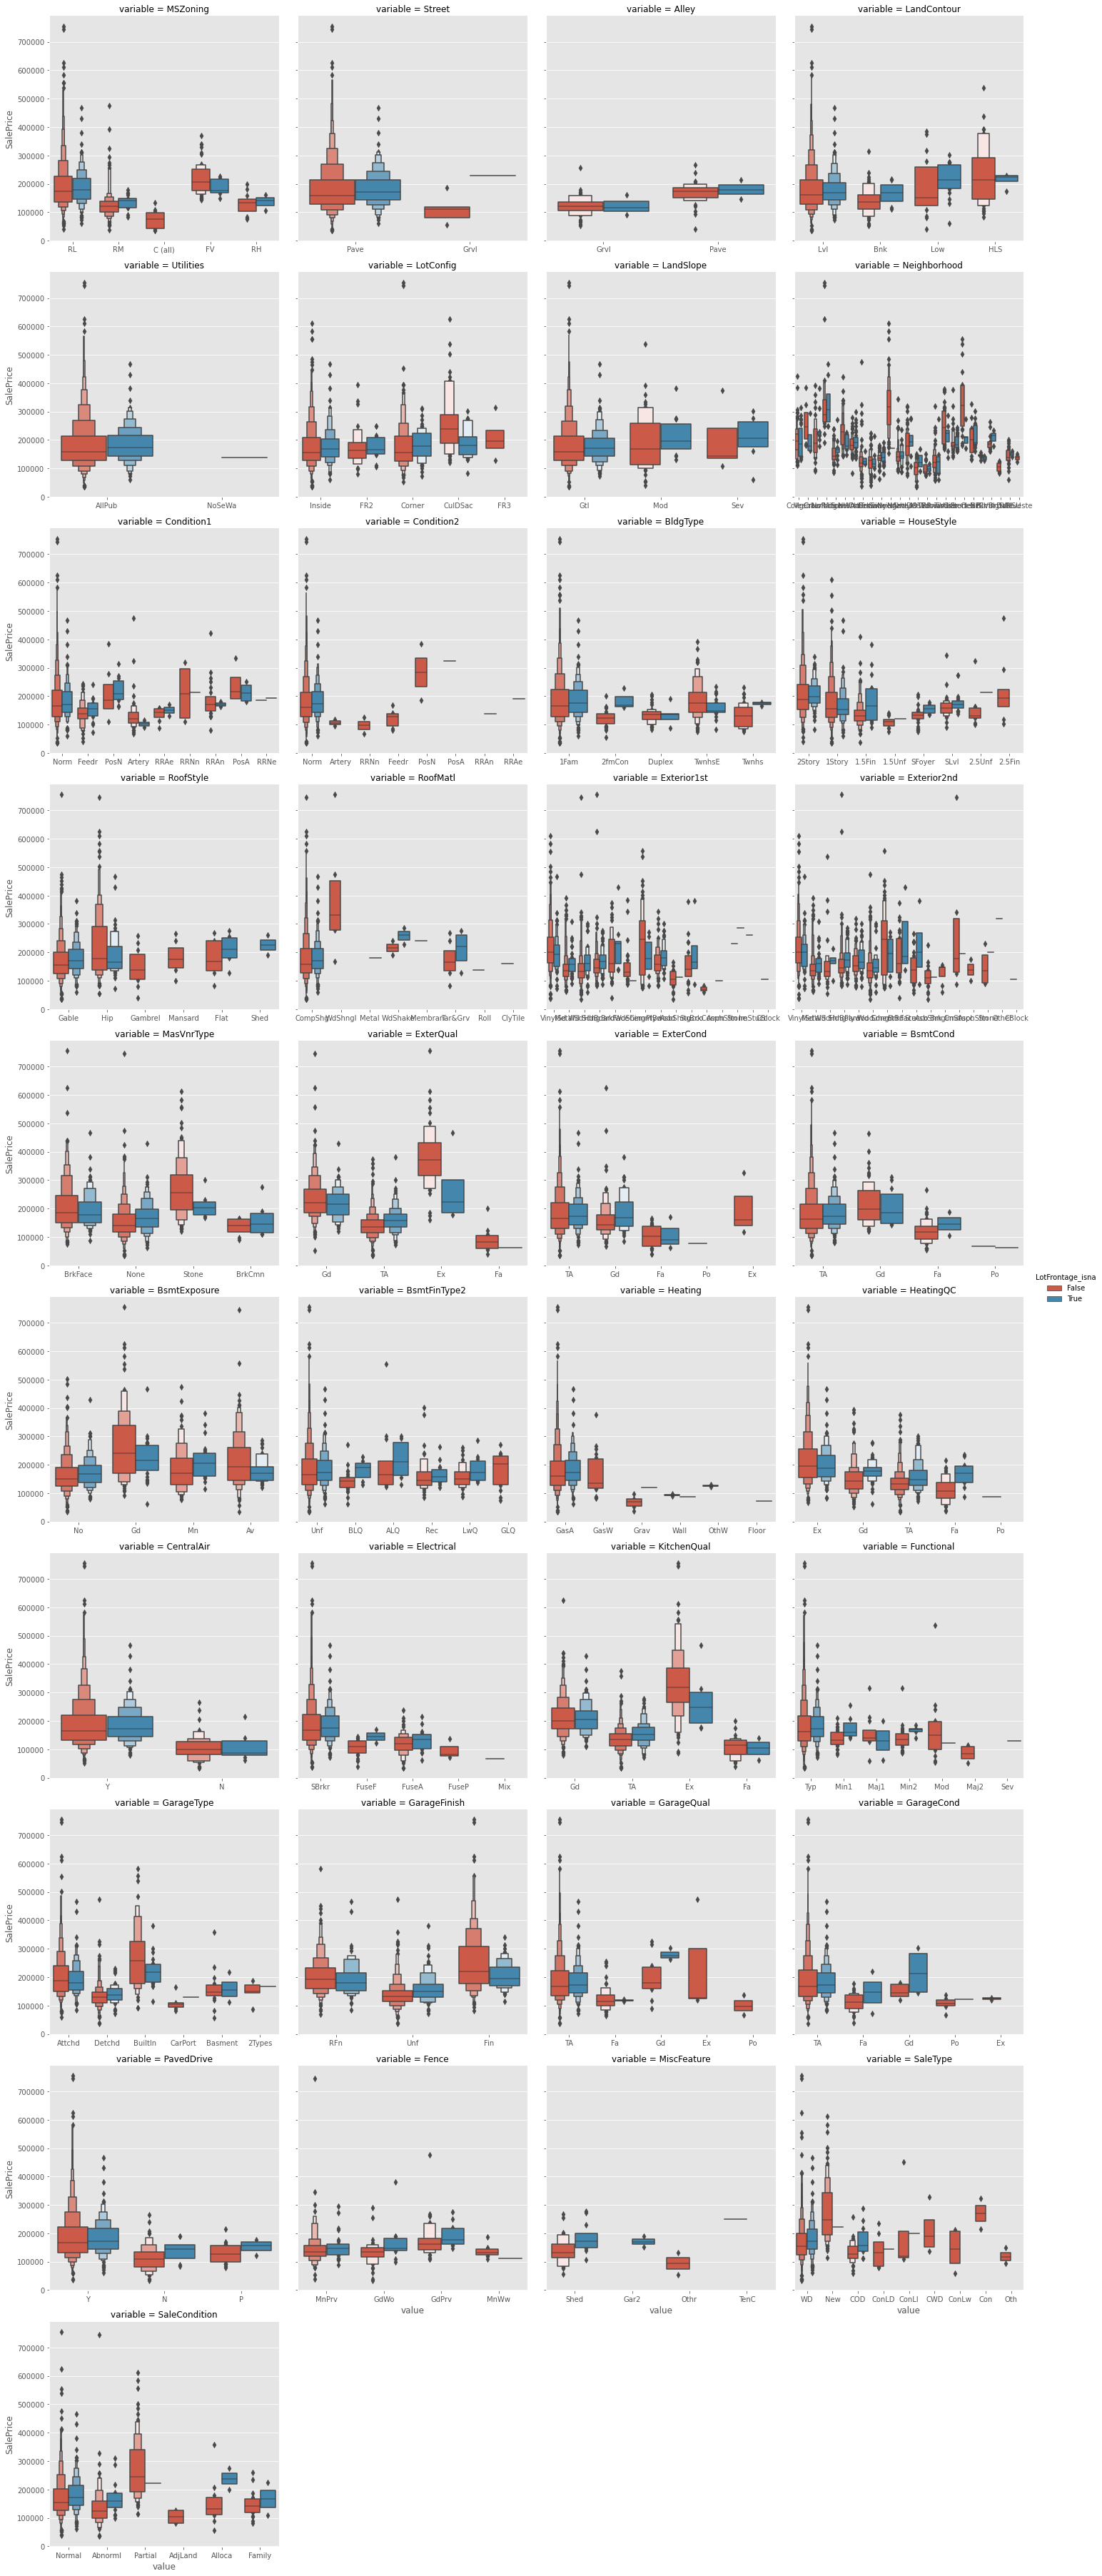

In [38]:
sns.catplot(
    data=df_train.assign(LotFrontage_isna=df_train.LotFrontage.isna())[columns_isna_lotfrontage_same_top+['LotFrontage_isna', 'SalePrice']].\
    melt(id_vars=['LotFrontage_isna', 'SalePrice']),
    x='value',
    col = 'variable',
    y='SalePrice',
    hue='LotFrontage_isna',
    #col_wrap=5,
    kind='boxen',
    sharex=False,
    col_wrap=4
)

#### 3.3.2 Find numeric  features that mean are same in with/without LotFrontage NA rows. And investigate if Price is associated with those features

In [39]:
np.isclose(
    df_train.loc[df_train.LotFrontage.isna(), :].describe(include='number').loc['mean', :],
    df_train.loc[~df_train.LotFrontage.isna(), :].describe(include='number').loc['mean', :],
    rtol=1e-3)

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False])

In [40]:
columns_isna_lotfrontage_same_top = df_train.select_dtypes('number').columns[np.isclose(
    df_train.loc[df_train.LotFrontage.isna(), :].describe(include='number').loc['mean', :],
    df_train.loc[~df_train.LotFrontage.isna(), :].describe(include='number').loc['mean', :],
    rtol=1e-3
)].tolist()
columns_isna_lotfrontage_same_top

['YearRemodAdd', 'GarageYrBlt', 'YrSold']

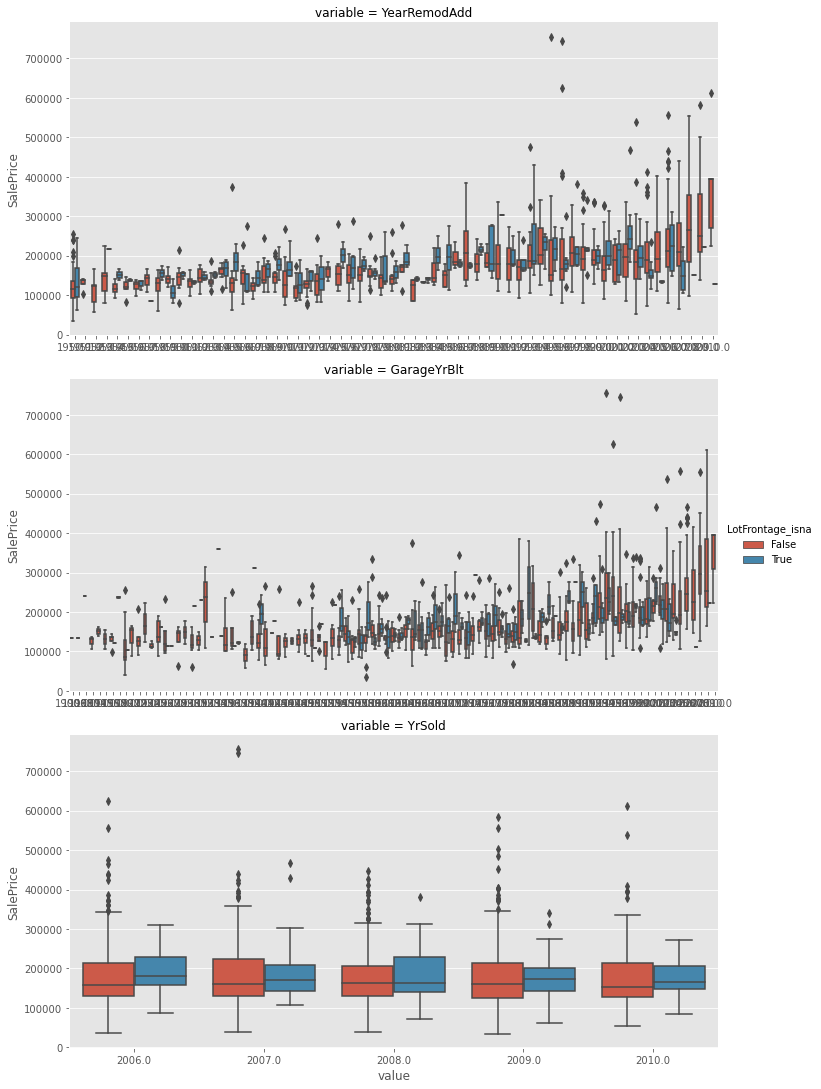

In [41]:
sns.catplot(
    data=df_train.assign(LotFrontage_isna=df_train.LotFrontage.isna())[columns_isna_lotfrontage_same_top+['LotFrontage_isna', 'SalePrice']].\
    melt(id_vars=['LotFrontage_isna', 'SalePrice']),
    x='value',
    col = 'variable',
    y='SalePrice',
    hue='LotFrontage_isna',
    #col_wrap=5,
    kind='box',
    sharex=False,
    col_wrap = 1,
    height=5, aspect=2
)

* It seems "LotFrontage" doesn't have a big effect on the "SalePrice", so we can fill missing with respective mean in train/test. 

In [42]:
def LotFrontage(X):
    X['LotFrontage'] = X['LotFrontage'].fillna(0)
    return X

In [43]:
X_4 = LotFrontage(X_3)
X_test_4 = LotFrontage(X_test_3)
df_combined_4 = LotFrontage(df_combined_3)

### 3.4 ''GarageYrBlt"

In [44]:
df_combined_4[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2919.000000,2919.000000,2760.000000,2919.000000
mean,1971.312778,1984.264474,1978.113406,2007.792737
std,30.291442,20.894344,25.574285,1.314964
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.500000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [45]:
df_combined_4.loc[df_combined_4['GarageYrBlt'].isnull(), :][['GarageYrBlt','GarageType']].style

,GarageYrBlt,GarageType
Id,,
40,nan,NA
49,nan,NA
79,nan,NA
89,nan,NA
90,nan,NA
100,nan,NA
109,nan,NA
126,nan,NA
128,nan,NA


* As we expected, for the columns with missing "GarageYrBlt", its "GarageType" is "NA", so we will fill the 'GarageYrBlt' with 0.

In [46]:
df_combined_4\
    .query("GarageYrBlt<YearBuilt|YrSold<YearBuilt|YearRemodAdd<YearBuilt")\
    [['YearBuilt', 'GarageYrBlt', 'YrSold', 'YearRemodAdd', 'set']]\
    .assign(issue_Garage=lambda x: x['GarageYrBlt']<x['YearBuilt'])

,YearBuilt,GarageYrBlt,YrSold,YearRemodAdd,set,issue_Garage
Id,,,,,,
30,1927,1920.0,2008,1950,train,True
94,1910,1900.0,2007,1998,train,True
325,1967,1961.0,2010,2007,train,True
601,2005,2003.0,2006,2005,train,True
737,1950,1949.0,2006,1950,train,True
1104,1959,1954.0,2006,1959,train,True
1377,1930,1925.0,2008,1950,train,True
1415,1923,1922.0,2008,2000,train,True
1419,1963,1962.0,2008,1963,train,True


In [47]:
df_combined_4.query('YrSold < YearBuilt | YearRemodAdd<YearBuilt | YrSold < GarageYrBlt')\
                [["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold",'GarageType', 'set']]

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,GarageType,set
Id,,,,,,
1877,2002,2001,2002.0,2009,Attchd,test
2550,2008,2009,2008.0,2007,Attchd,test
2593,2006,2007,2207.0,2007,Attchd,test


In [48]:
df_combined_4.query('GarageYrBlt<YearBuilt')\
                [["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold", 'GarageType','set']]

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,GarageType,set
Id,,,,,,
30,1927,1950,1920.0,2008,Detchd,train
94,1910,1998,1900.0,2007,Detchd,train
325,1967,2007,1961.0,2010,BuiltIn,train
601,2005,2005,2003.0,2006,BuiltIn,train
737,1950,1950,1949.0,2006,Detchd,train
1104,1959,1959,1954.0,2006,BuiltIn,train
1377,1930,1950,1925.0,2008,Detchd,train
1415,1923,2000,1922.0,2008,Detchd,train
1419,1963,1963,1962.0,2008,Detchd,train


In [49]:
def wrong_date(X):
    X.loc[X['GarageYrBlt'] < X['YearBuilt'], 'GarageYrBlt'] = X.loc[X['GarageYrBlt'] < X['YearBuilt'], 'YearBuilt']
    X.loc[X['YrSold'] < X['YearBuilt'], 'YrSold'] = X.loc[X['YrSold'] < X['YearBuilt'], 'YearRemodAdd']
    X.loc[X['YearRemodAdd'] < X['YearBuilt'], 'YearRemodAdd'] = X.loc[X['YearRemodAdd'] < X['YearBuilt'], 'YearBuilt']
    X.loc[X['GarageYrBlt'] == 2207, 'GarageYrBlt'] = X.loc[X['GarageYrBlt'] == 2207, 'YearRemodAdd']
    X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0)
    return X

In [50]:
X_5 = wrong_date(X_4)
X_test_5 = wrong_date(X_test_4)
df_combined_5 = wrong_date(df_combined_4)

In [51]:
df_combined_5.query('YrSold < YearBuilt | YearRemodAdd<YearBuilt | YrSold < GarageYrBlt')\
                [["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold",'GarageType', 'set']]

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,GarageType,set
Id,,,,,,


In [52]:
df_combined_4.query('GarageYrBlt<YearBuilt')\
                [["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold", 'GarageType','set']]

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,GarageType,set
Id,,,,,,
40,1955,1955,0.0,2008,NA,train
49,1920,2008,0.0,2009,NA,train
79,1968,1968,0.0,2010,NA,train
89,1915,1982,0.0,2009,NA,train
90,1994,1995,0.0,2007,NA,train
...,...,...,...,...,...,...
2894,1916,1950,0.0,2006,NA,test
2910,1970,1970,0.0,2006,NA,test
2914,1970,1970,0.0,2006,NA,test


In [53]:
df_combined_5.isnull().sum().value_counts()

0    80
dtype: int64

### 3.5 fix typing errors in some features

In [54]:
dict_wrong = {"Exterior2nd": {"CmentBd": "CemntBd",
                              "Brk Cmn":"BrkComm",
                              "Wd Shng": "WdShing"}}

def wrong_type(X):
    # fix int value but has no numeric meaning
    X['MSSubClass'] = X['MSSubClass'].astype('object')
    return X.replace(dict_wrong)

### 3.6 power transfromation to y and area-related numerical features

### 3.6.1 SalePrice

In [55]:
import statsmodels.api as sm
import scipy.stats as stats

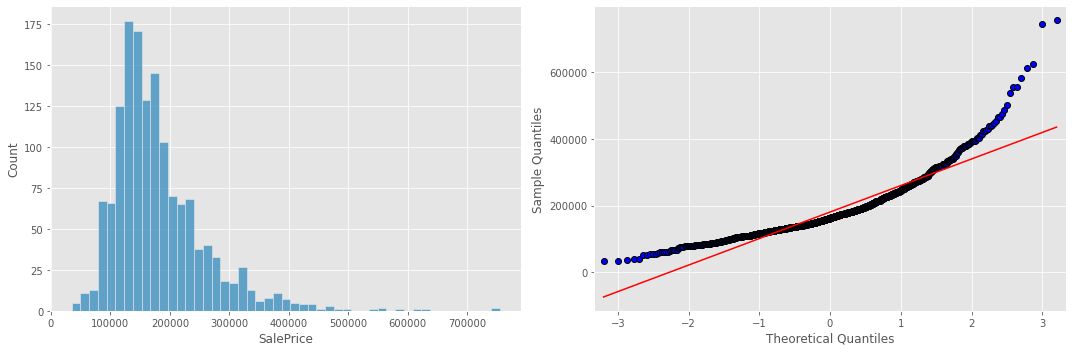

In [56]:
fix, ax = plt.subplots(1, 2, figsize = (15,5))
sns.histplot(x=y, ax = ax[0])
sm.ProbPlot(y).qqplot(line='s', ax=ax[1], fmt='k')
plt.tight_layout()

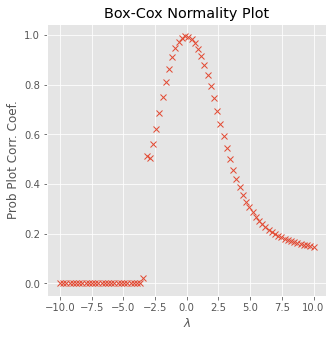

In [57]:
fig, ax = plt.subplots(figsize = (5,5))
stats.boxcox_normplot(y, -10,10,plot=ax);

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

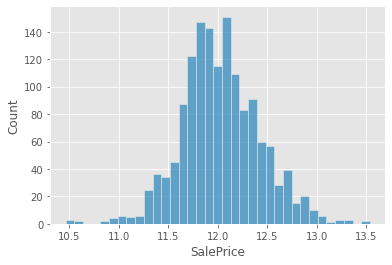

In [58]:
sns.histplot(np.log(y))

* SalePrice can be directly log converted

### 3.6.2 Power transformation to area-related features

In [59]:
from sklearn import preprocessing 

In [60]:
columns_discrete = X.select_dtypes('object').columns.tolist()
columns_discrete = columns_discrete + ['MSSubClass', 'OverallQual', 'OverallCond']
columns_discrete, len(columns_discrete)

(['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Heating',
  'HeatingQC',
  'CentralAir',
  'Electrical',
  'KitchenQual',
  'Functional',
  'FireplaceQu',
  'GarageType',
  'GarageFinish',
  'GarageQual',
  'GarageCond',
  'PavedDrive',
  'PoolQC',
  'Fence',
  'MiscFeature',
  'SaleType',
  'SaleCondition',
  'MSSubClass',
  'OverallQual',
  'OverallCond'],
 46)

C:\Anacoda\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Anacoda\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Anacoda\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


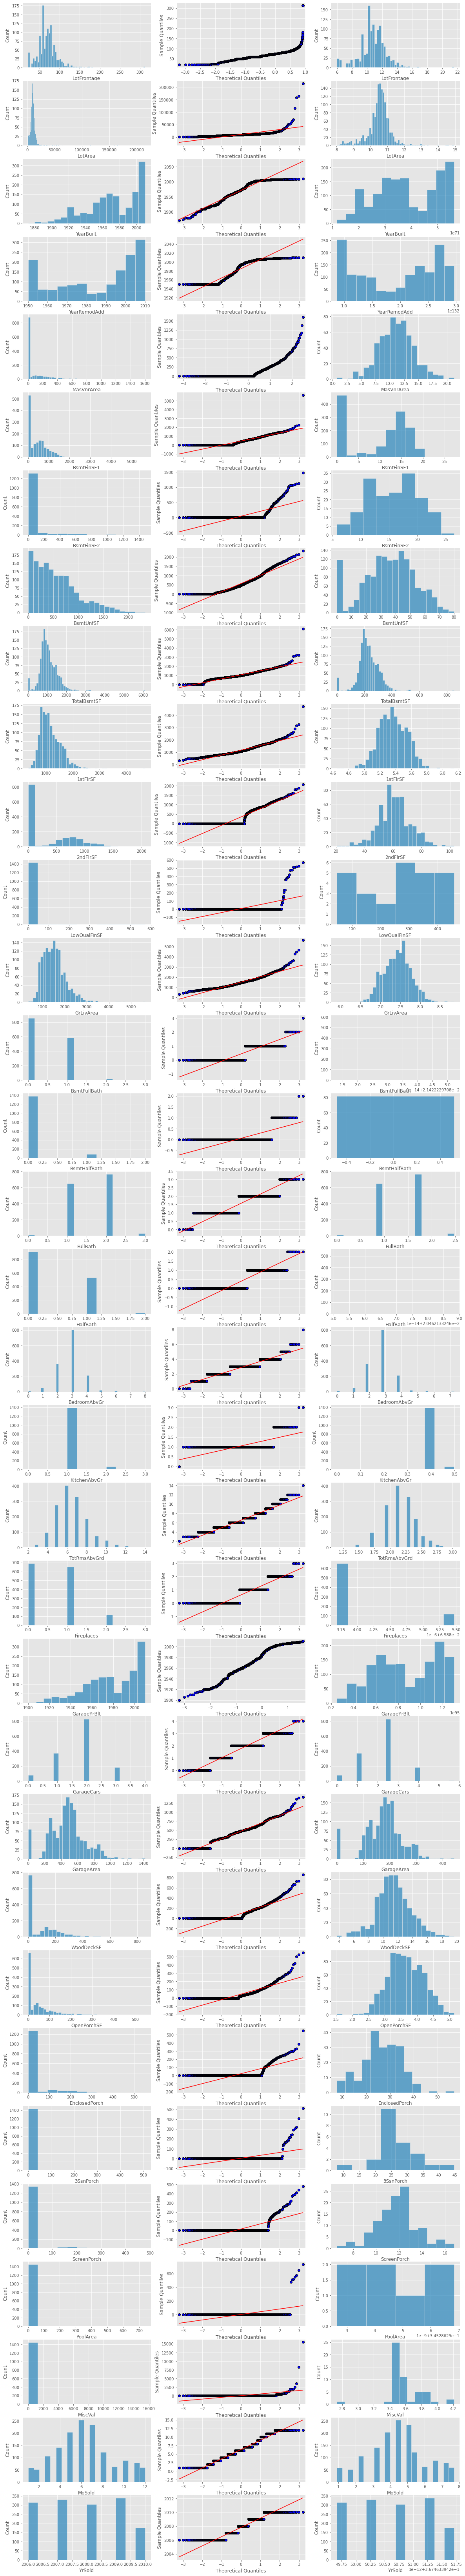

In [61]:
# exclue 'MSSubClass', 'OverallQual', 'OverallCond'
num_feature =  X.drop(columns=columns_discrete).select_dtypes('number')

# visualize them
fig, ax = plt.subplots(num_feature.shape[1], 3, figsize = (20,120))
for i, c in enumerate(num_feature.columns):
#     print(num_feature[c])
    sns.histplot(x=num_feature[c], ax=ax[i, 0])
    sm.ProbPlot(num_feature[c]).qqplot(line='s', ax=ax[i, 1], fmt='k')
    
    zero_skewed = (num_feature[c] == 0).sum() > (num_feature[c].shape[0] / 3)
    is_negative = (min(num_feature[c]) <= 0)
    
    if zero_skewed:
        num_feature[c] = num_feature[c].replace(0, np.NaN).dropna()
    else:
        num_feature[c] = num_feature[c].dropna()
    
    
    if is_negative:
        pt = preprocessing.PowerTransformer(method = 'yeo-johnson', standardize=False)
        fitted = pt.fit_transform(num_feature[c].to_frame())
        fitted = pd.DataFrame(fitted,index = num_feature[c].index, columns = [c])
    else:
        pt = preprocessing.PowerTransformer(standardize=False)
        fitted = pt.fit_transform(num_feature[c].to_frame())
        fitted = pd.DataFrame(fitted, index = num_feature[c].index, columns = [c] )
#     print(fitted)
    sns.histplot(data=fitted, x = c,  ax=ax[i, 2])
#     sns.histplot(x=fitted, ax=ax[i, 2])

In [62]:
# area_related freatures
area_col = num_feature.columns[num_feature.columns.str.contains('Area|SF|Porch$|MiscVal')]
area_col

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [63]:
def area_scaling(X):
    area_col = X.columns[X.columns.str.contains('Area|SF|Porch$|MiscVal')]
    X[area_col] = preprocessing.power_transform(X[area_col])
    return X

# 4. Pre-processing summary

In [493]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

### 4.1 combine all previous processing methods

In [522]:
def proc(X):
    return X.pipe(fill_NA)\
            .pipe(fill_NA_object)\
            .pipe(fill_NA_num)\
            .pipe(LotFrontage)\
            .pipe(wrong_date)\
            .pipe(wrong_type)\
            .pipe(to_ordered_categories)

In [523]:
X_temp = proc(X)

In [524]:
X_proc = proc(X)
X_test_proc = proc(X_test)
df_combined_proc = proc(df_combined)

In [525]:
y_proc = np.log(y)

In [526]:
df_combined_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2919 non-null   object  
 1   MSZoning       2919 non-null   object  
 2   LotFrontage    2919 non-null   float64 
 3   LotArea        2919 non-null   int64   
 4   Street         2919 non-null   category
 5   Alley          2919 non-null   category
 6   LotShape       2919 non-null   category
 7   LandContour    2919 non-null   category
 8   Utilities      2919 non-null   category
 9   LotConfig      2919 non-null   object  
 10  LandSlope      2919 non-null   category
 11  Neighborhood   2919 non-null   object  
 12  Condition1     2919 non-null   object  
 13  Condition2     2919 non-null   object  
 14  BldgType       2919 non-null   object  
 15  HouseStyle     2919 non-null   object  
 16  OverallQual    2919 non-null   int64   
 17  OverallCond    2919 non-null   in

### 4.2 Object freature encoding

In [527]:
def obj_encoding(train, test):
    obj_col_train = train.select_dtypes('object').columns.tolist()
    obj_col_test = test.select_dtypes('object').columns.tolist()

    drop_list_train, drop_list_test  = [], []
        
    for column in obj_col_train:
        enc = OneHotEncoder()
        ohe = enc.fit_transform(train[[column]]).toarray()
        cols = [column + "_" + str(enc.categories_[0][i]) for i in range(len(enc.categories_[0]))]
        train_ohe = pd.DataFrame(ohe, columns=cols, index = train[column].index)
        
        drop_list_train.append(column)
        train = pd.concat([train, train_ohe], axis=1) 
    
    for column in obj_col_test:
        enc = OneHotEncoder()
        ohe = enc.fit_transform(test[[column]]).toarray()
        cols = [column + "_" + str(enc.categories_[0][i]) for i in range(len(enc.categories_[0]))]
        test_ohe = pd.DataFrame(ohe, columns=cols, index =test[column].index )
#         print(column)
#         print(test_ohe.shape)
#         print(test_ohe.head())
        
        drop_list_test.append(column)
        test = pd.concat([test, test_ohe], axis=1)
#         print(test.shape)
#         print(test.head())
#         exit(0)
    
    
    train = train.drop(drop_list_train, axis=1)
    test = test.drop(drop_list_test, axis=1)
#     print(drop_list_test)
#     print(train.shape)
#     print(test.shape)
    
    train, test = train.align(test, join='inner', axis=1)
    return train, test
    

In [528]:
train = X_proc.copy()
test = X_test_proc.copy()
print(train.shape)
print(test.shape)

(1460, 79)
(1459, 79)


In [529]:
train, test = obj_encoding(train, test)

In [530]:
X_proc, X_test_proc = obj_encoding(X_proc, X_test_proc)

In [531]:
X_proc.shape

(1460, 219)

In [532]:
X_test_proc.shape

(1459, 219)

### 4.3 Stratifiedkfold for y_proc
* ensure that each fold of dataset has the same proportion of observations with a given label.
* good for imbalanced dataset

In [533]:
random_state = 42

In [369]:
# Evenly split y(normal_distributed) into 10 bins
pd.qcut(y_proc, 10).factorize(sort = True)

(array([7, 6, 7, ..., 8, 3, 4], dtype=int64),
 CategoricalIndex([(10.459000000000001, 11.576],             (11.576, 11.728],
                               (11.728, 11.817],             (11.817, 11.898],
                               (11.898, 12.002],             (12.002, 12.097],
                               (12.097, 12.199],             (12.199, 12.346],
                               (12.346, 12.535],             (12.535, 13.534]],
                  categories=[(10.459000000000001, 11.576], (11.576, 11.728], (11.728, 11.817], (11.817, 11.898], (11.898, 12.002], (12.002, 12.097], (12.097, 12.199], (12.199, 12.346], ...], ordered=True, dtype='category'))

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

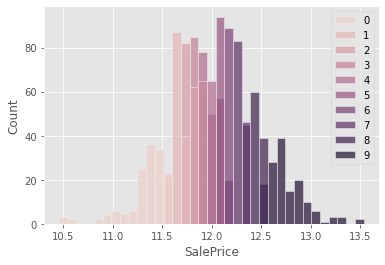

In [370]:
y_encoded, _ = pd.qcut(y_proc, 10).factorize(sort = True)
sns.histplot(x=y_proc, hue=y_encoded)

In [371]:
def get_folds(X, y):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_encoded, _ = pd.qcut(y, 10).factorize()
    # return train_index, test_index in each split
    # note: X shouldn't have missings 
    return folds.split(X, y_encoded)

In [372]:
# quick demonstration
X_demo = X_proc.copy()
X_demo['LotFrontage'] = X_demo['LotFrontage'].fillna(0)

folds_index = pd.DataFrame(np.full((y.shape[0], 5), -1),
                           index=y.index,
                           columns=[f'fold{x}' for x in range(5)])

In [373]:
folds_index = pd.DataFrame(np.full((y.shape[0], 5), -1),
                           index=y_proc.index,
                           columns=[f'fold{x}' for x in range(5)])
for i, (train_index, test_index) in enumerate(get_folds(X_demo, y_proc)):
    folds_index.iloc[train_index,i] = 0
    folds_index.iloc[test_index,i] = 1
folds_index.apply(lambda x: x.value_counts())

,fold0,fold1,fold2,fold3,fold4
0,1168,1168,1168,1168,1168
1,292,292,292,292,292


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

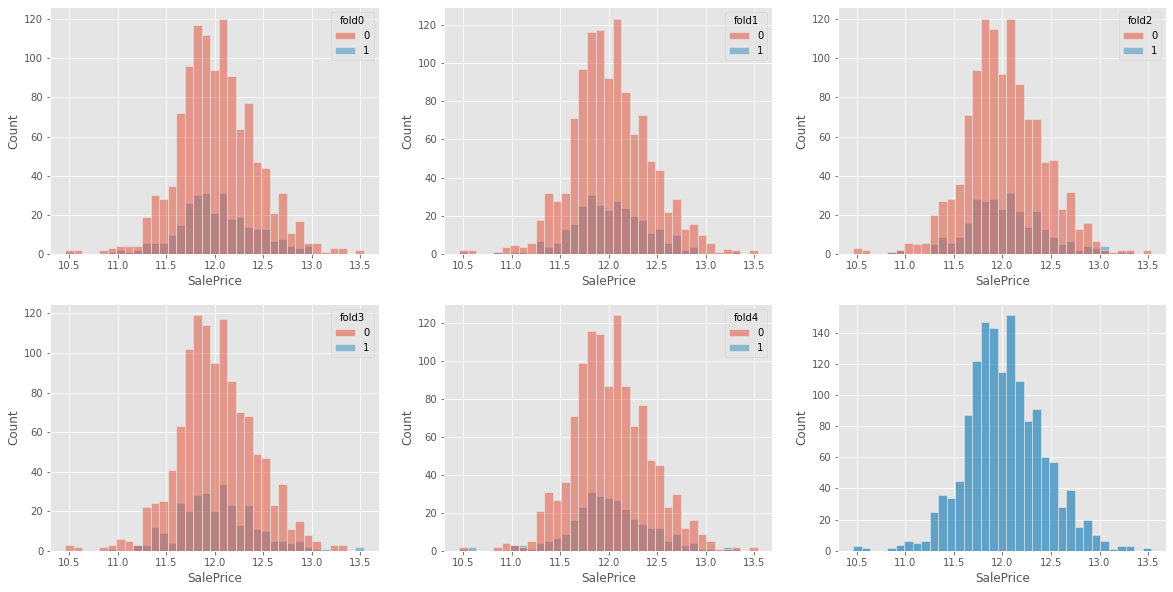

In [374]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flat

for i, c in enumerate(folds_index.columns):
    sns.histplot(x=y_proc,
                hue=folds_index.iloc[:, i],
                ax=axs[i])

sns.histplot(x=y_proc, ax=axs[5])

* From above graphes, it is clear to see that in each fold, both train and test follow original distribution(normal distribution)

# 5. Build base model for later feature engineering evaluations

* choose three models "xgb" "lgb" "ridge" as baselines.
* Dummyregressor as a "rule of thumb"

In [375]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

In [376]:
cross_val_score(DummyRegressor(), X_proc, y_proc, cv=5, scoring='neg_root_mean_squared_error')

array([-0.3867785 , -0.4251402 , -0.40997109, -0.38299932, -0.39125229])

In [377]:
def calculate_score(X, y, pipe=None):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    y_encoded, _ = pd.qcut(y, q=10).factorize()
    cv = folds.split(X, y_encoded)

    
    estimator = Pipeline([("proc", pipe),
                          ("_dtype_", 'passthrough'),
                          ("model", DummyRegressor())])
    models = [lgb.LGBMRegressor(objective="rmse", random_state=random_state, n_jobs=1),  Ridge()]
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                                 eval_metric='rmse',
                                 random_state=random_state,
#                                  enable_categorical=True,
                                 n_jobs=1)
    
    
    def convert_cat_to_int(X):
        # columntransformer will generate ndarray, doesn't have "select_dtypes"
        if not isinstance(X, pd.DataFrame):
            return X
        
        cat_cols = X.select_dtypes("category").columns
        X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
        print(X)
        return X    
    
    transformer_cat_to_int = preprocessing.FunctionTransformer(convert_cat_to_int)
    
    param_grid = [{'_dtype_':['passthrough'], 'model':models},
                  {'_dtype_':[transformer_cat_to_int], 'model': [xgb_model]}]
                 
    
    gscv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=4,
        refit=False,
        cv=cv,
        error_score='raise',
        return_train_score=True,
    )
    
    gscv.fit(X, y)
    
    
    r = pd.DataFrame(gscv.cv_results_, index = ['LGB','Ridge','XGB'] )
    r = r[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']] * (-1)
#     r = r.applymap(lambda x: type(x).__name__).set_index("param_model").sort_index()
    return r

In [378]:
base_score = calculate_score(X_proc, y_proc)
base_score

,mean_train_score,std_train_score,mean_test_score,std_test_score
LGB,0.042202,-0.002408,0.137671,-0.021353
Ridge,0.103202,-0.005896,0.156122,-0.035163
XGB,0.008384,-0.000989,0.146990,-0.016862


In [379]:
def test_new(*args,X = X_proc, y = y_proc, pipe = None):
    new_features = []
    for i, new in enumerate(args):
        if isinstance(new, pd.Series):
            new = new.rename(f'new{i}')
        new_features.append(new)

        
    # calculate new score after introducing new features into train dataframe
    new_score = calculate_score(X.join(new_features), y, pipe = pipe)
    # combine base score and new score
    r = base_score.add_prefix('base-').join(new_score.add_prefix('new-'))
    r = r.assign(mean_diff = (r['new-mean_test_score'] - r['base-mean_test_score']), 
                 std_diff = (r['new-std_test_score'] - r['base-std_test_score']))
    
    return r
                 

# 6. Feature engineering - Univariate

### 6.1 The existance of firplace, garage, basement. They all have been introduced during OneHot encoding.

In [380]:
X_proc.loc[X_proc['GarageType_NA']==1, 'GarageType_NA'].index

Int64Index([  40,   49,   79,   89,   90,  100,  109,  126,  128,  141,  149,
             156,  164,  166,  199,  211,  242,  251,  288,  292,  308,  376,
             387,  394,  432,  435,  442,  465,  496,  521,  529,  534,  536,
             563,  583,  614,  615,  621,  636,  637,  639,  650,  706,  711,
             739,  751,  785,  827,  844,  922,  943,  955,  961,  969,  971,
             977, 1010, 1012, 1031, 1039, 1097, 1124, 1132, 1138, 1144, 1174,
            1180, 1219, 1220, 1235, 1258, 1284, 1324, 1326, 1327, 1338, 1350,
            1408, 1450, 1451, 1454],
           dtype='int64', name='Id')

### 6.2.1 Effect of power transformation to area_related features

In [381]:
area_col

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [382]:
pipe_area = ColumnTransformer([('area', preprocessing.PowerTransformer(), area_col)], remainder='passthrough')
test_new(pipe = pipe_area)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042149,-0.002524,0.137831,-0.021532,0.000160,-0.000178
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.099131,-0.004510,0.140002,-0.024464,-0.016120,0.010699
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008152,-0.001173,0.147481,-0.016139,0.000491,0.000723


### 6.2.2  Effect of square root to area_related features

In [383]:
pipe_area = ColumnTransformer([('area', preprocessing.FunctionTransformer(lambda x: np.sqrt(x+1)), area_col)], remainder='passthrough')
test_new(pipe = pipe_area)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042299,-0.002191,0.139032,-0.021577,0.001362,-0.000224
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.099976,-0.004844,0.143821,-0.025172,-0.012301,0.009991
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008384,-0.000989,0.146971,-0.017198,-0.000019,-0.000336


* Comparing above two transformers to area features, it seems sqrt root transformation is more effective

### 6.3 Mutual inforamtion between target(y) and features

* It measures how much a given feature can explain another (target).

In [384]:
from sklearn.feature_selection import mutual_info_regression

In [385]:
# need to specifiy "category" features in the below function
X_proc.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 219 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   LotFrontage            1460 non-null   float64 
 1   LotArea                1460 non-null   int64   
 2   Street                 1460 non-null   category
 3   Alley                  1460 non-null   category
 4   LotShape               1460 non-null   category
 5   LandContour            1460 non-null   category
 6   Utilities              1460 non-null   category
 7   LandSlope              1460 non-null   category
 8   OverallQual            1460 non-null   int64   
 9   OverallCond            1460 non-null   int64   
 10  YearBuilt              1460 non-null   int64   
 11  YearRemodAdd           1460 non-null   int64   
 12  MasVnrArea             1460 non-null   float64 
 13  ExterQual              1460 non-null   category
 14  ExterCond              1460 non-null   

In [386]:
def mutual_info(X, y):
    col_discrete = X.select_dtypes(['object', 'category'])
    bool_discrete = X.columns.isin(col_discrete)
    
    # mi is a ndarray with estimated mutual information between each feature and the target
    mi = mutual_info_regression(X, y, discrete_features = bool_discrete, random_state = random_state)
    mi_series = pd.Series(mi, index = X.columns, name = 'mutual_info').sort_values(ascending = False)
    
    return mi_series

In [387]:
mi_series = mutual_info(X_proc, y_proc)

In [388]:
mi_series_df = mi_series.to_frame()
mi_series_df.style

,mutual_info
OverallQual,0.573991
GrLivArea,0.458984
TotalBsmtSF,0.361386
GarageArea,0.360966
YearBuilt,0.360077
GarageCars,0.358133
BsmtQual,0.324929
ExterQual,0.323799
KitchenQual,0.322388
1stFlrSF,0.298940


#### Test the effect of discarding low correlated features

In [389]:
mi_series

OverallQual            0.573991
GrLivArea              0.458984
TotalBsmtSF            0.361386
GarageArea             0.360966
YearBuilt              0.360077
                         ...   
Exterior1st_Stucco     0.000000
Foundation_Wood        0.000000
Exterior2nd_AsphShn    0.000000
Exterior2nd_BrkFace    0.000000
PoolQC                 0.000000
Name: mutual_info, Length: 219, dtype: float64

In [390]:
X_proc_mi = X_proc.loc[:, mi_series > 1e-4]
test_new(X=X_proc_mi)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.043276,-0.002747,0.139024,-0.021520,0.001354,-0.000166
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.108935,-0.007664,0.144470,-0.038424,-0.011652,-0.003261
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008571,-0.000835,0.147721,-0.018993,0.000731,-0.002131


* Effect is not significant

### Summary
* square root to area_related features

# 7. Feature engineering - Bivariate

### 7.1 Feature correlations, numerical vs. numerical

In [391]:
col_num = X.select_dtypes(exclude = ['category', 'object']).columns
col_num

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [392]:
X_corr_num = X[col_num].astype(float).corr(method='spearman')

In [393]:
X_corr_num.apply(lambda x: x.abs() > 0.5).dropna(thresh=4, axis=0).index

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

* Given large numbers of hight correlated numerical features, it is impossible to check them one by one.
* I will choose several features driven by intuition

In [394]:
test_new(
        X_proc.eval('GrLivArea / (TotRmsAbvGrd + FullBath + HalfBath)')
#         X_proc.eval('(`1stFlrSF` + `2ndFlrSF`) / (`TotRmsAbvGrd` + `FullBath` + `HalfBath`)'),
#         X_proc.eval('(`TotRmsAbvGrd` + `FullBath` + `HalfBath`)'
)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.041901,-0.002324,0.138819,-0.020654,0.001148,0.000699
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.100949,-0.005131,0.150947,-0.033321,-0.005176,0.001841
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008432,-0.000695,0.145808,-0.014485,-0.001182,0.002377


In [395]:
test_new(
        X_proc.eval('(GrLivArea + TotalBsmtSF) / (TotRmsAbvGrd + FullBath + HalfBath)')
)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.041851,-0.002245,0.138833,-0.021257,0.001162,0.000096
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.101033,-0.005044,0.151080,-0.032817,-0.005043,0.002345
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008862,-0.000751,0.147545,-0.019122,0.000555,-0.002260


In [396]:
test_new(
        X_proc.eval('OverallQual * OverallCond')
)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042137,-0.002487,0.138513,-0.020348,0.000842,0.001005
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103147,-0.005926,0.156166,-0.035182,0.000044,-0.000020
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008355,-0.000877,0.146491,-0.017529,-0.000499,-0.000666


In [397]:
test_new(
        X_proc.eval('(GrLivArea + TotalBsmtSF) / (TotRmsAbvGrd + FullBath + HalfBath)'),
        X_proc.eval('OverallQual * OverallCond')
)
# will use these new two features later

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.041834,-0.002370,0.137567,-0.020557,-0.000104,0.000797
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.100928,-0.005044,0.150868,-0.032735,-0.005254,0.002428
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008801,-0.001213,0.145659,-0.018826,-0.001330,-0.001964


In [398]:
# test_new(
#     X_proc.astype(int).eval('GarageQual * GarageCond'),
#     X_proc.astype(int).eval('Fireplaces * FireplaceQu'),
#     X_proc.astype(int).eval('PoolArea * PoolQC'),
#     X_proc.eval('OverallQual * YearBuilt')
# )

### 7.2 PCA to reduce dimensionality

In [399]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [400]:
def PCA_test(df_X, selected_cols=None, variance_explained_thre=0.8):
    
    index = df_X.index
    X = df_X.copy()
    if selected_cols:
        X = X[selected_cols]
    
    # first convert category features into numerical values
    cat_cols = X.select_dtypes("category").columns
    X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
    
    X = StandardScaler().fit_transform(X)
    
    pca = PCA(n_components=variance_explained_thre).fit(X)
    pd.DataFrame(pca.explained_variance_ratio_).plot.bar(figsize=(15, 6))
    
    
#     temp = pd.DataFrame(pca.components_.T, index=columns)
#     temp = pd.concat([mi_series_df, temp], axis = 1)

    X_pca = pd.DataFrame(pca.transform(X), index=index)
    
    return X_pca

    

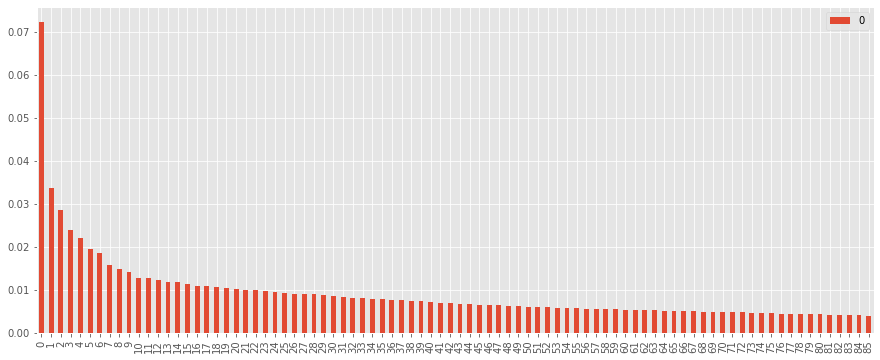

In [401]:
X_pca = PCA_test(X_proc, variance_explained_thre=0.8)

In [402]:
test_new(X_pca)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.026520,-0.001773,0.136863,-0.017944,-0.000807,0.003409
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.101872,-0.005494,0.168473,-0.033879,0.012351,0.001283
XGB,0.008384,-0.000989,0.146990,-0.016862,0.000552,-0.000034,0.145745,-0.011984,-0.001245,0.004879


In [403]:
display(test_new(X_pca.iloc[:, 0]))

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042974,-0.002517,0.137084,-0.019266,-0.000587,0.002088
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103221,-0.005905,0.156109,-0.035186,-0.000014,-0.000024
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008154,-0.000252,0.139243,-0.019042,-0.007747,-0.002179


# 8. Feature engineering - Multivariate

### 8.1 PCA to strongly correlated features

In [404]:
X_corr_num.where(lambda x: x.abs() > 0.5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,NaN,1.000000,0.649633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotArea,NaN,0.649633,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,NaN,NaN,NaN,1.000000,NaN,0.647392,0.557723,NaN,NaN,NaN,...,0.541552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallCond,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearBuilt,NaN,NaN,NaN,0.647392,NaN,1.000000,0.684388,NaN,NaN,NaN,...,0.528281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YearRemodAdd,NaN,NaN,NaN,0.557723,NaN,0.684388,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MasVnrArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BsmtFinSF2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [405]:
# Stronger correlated features 
X_corr_num.where(lambda x: x.abs() > 0.5).dropna(thresh=4, axis = 0).index

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea'],
      dtype='object')

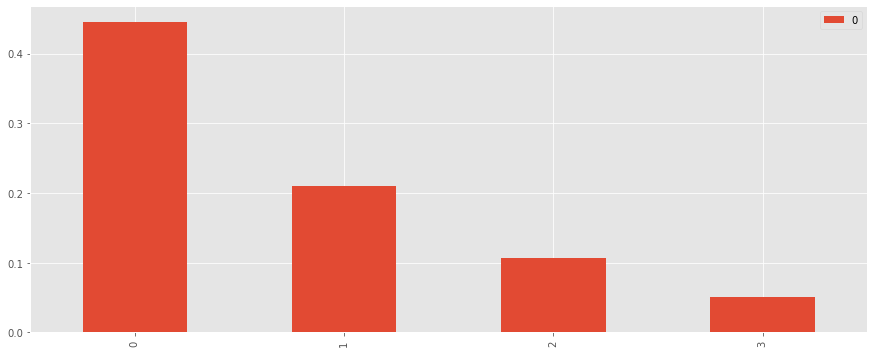

In [406]:
# compress those strongly correlated into PCA components
X_pca = PCA_test(X_proc, selected_cols=list(X_corr_num.where(lambda x: x.abs() > 0.5).dropna(thresh=4, axis=0).index))

In [407]:
# test effect of appending PCA[0]
test_new(X_pca.iloc[:, 0])

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.041665,-0.002178,0.137704,-0.020456,0.000033,0.000897
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103203,-0.005896,0.156115,-0.035149,-0.000007,0.000013
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008299,-0.000492,0.144678,-0.021566,-0.002312,-0.004704


### 8.2 PCA to area-related features

In [408]:
area_col

Index(['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

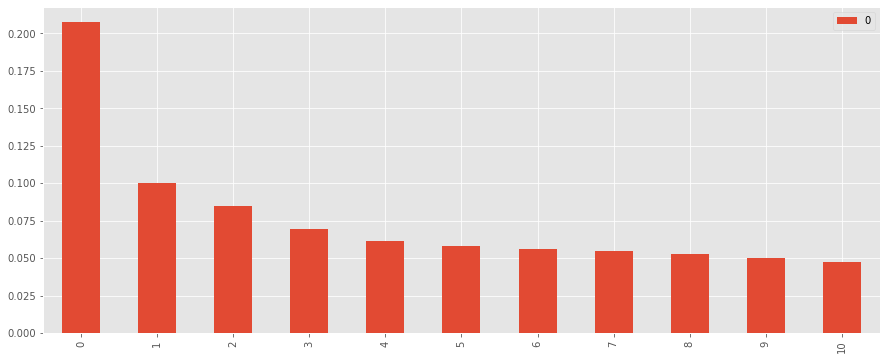

In [409]:
area_PCA = PCA_test(X_proc, selected_cols = list(area_col))

In [410]:
test_new(area_PCA[0])

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.044182,-0.002574,0.137013,-0.019073,-6.574649e-04,2.280420e-03
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103202,-0.005896,0.156122,-0.035163,2.528533e-13,-1.132913e-13
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008167,-0.000575,0.135561,-0.021905,-1.142932e-02,-5.043032e-03


### 8.3 Digging underlying features

### 8.3.1 groupby('Neighborhood')['GrLivArea'].transform('mean')

In [411]:
X_temp.groupby('Neighborhood')['GrLivArea'].transform('mean')

Id
1       1480.500000
2       1539.636364
3       1480.500000
4       1791.607843
5       2508.853659
           ...     
1456    1641.316456
1457    1727.780822
1458    1791.607843
1459    1310.311111
1460    1340.040000
Name: GrLivArea, Length: 1460, dtype: float64

In [412]:
# 'Neighborhood' in X_proc has been encoded, so I re-use original X dataframe
test_new(X_temp.groupby('Neighborhood')['GrLivArea'].transform('mean'))

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.040097,-0.001757,0.136003,-0.019339,-0.001668,0.002014
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103197,-0.005898,0.155976,-0.034874,-0.000146,0.000289
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008370,-0.000521,0.146458,-0.017571,-0.000532,-0.000709


In [413]:
test_new(X_temp.groupby('MSSubClass')['GrLivArea'].transform('mean'))

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042813,-0.002629,0.138014,-0.021087,0.000343,0.000267
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103197,-0.005895,0.156113,-0.035168,-0.000009,-0.000005
XGB,0.008384,-0.000989,0.146990,-0.016862,0.009044,-0.000731,0.150495,-0.017815,0.003505,-0.000952


In [414]:
test_new(X_temp.groupby(['Neighborhood', 'MSSubClass'])['GrLivArea'].transform('mean'))

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042238,-0.002357,0.139566,-0.020010,0.001895,0.001344
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103061,-0.005872,0.156232,-0.035831,0.000110,-0.000668
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008545,-0.000696,0.144282,-0.015037,-0.002708,0.001826


### 8.3.2 predict 'SalePrice' by 'GrLivArea' 

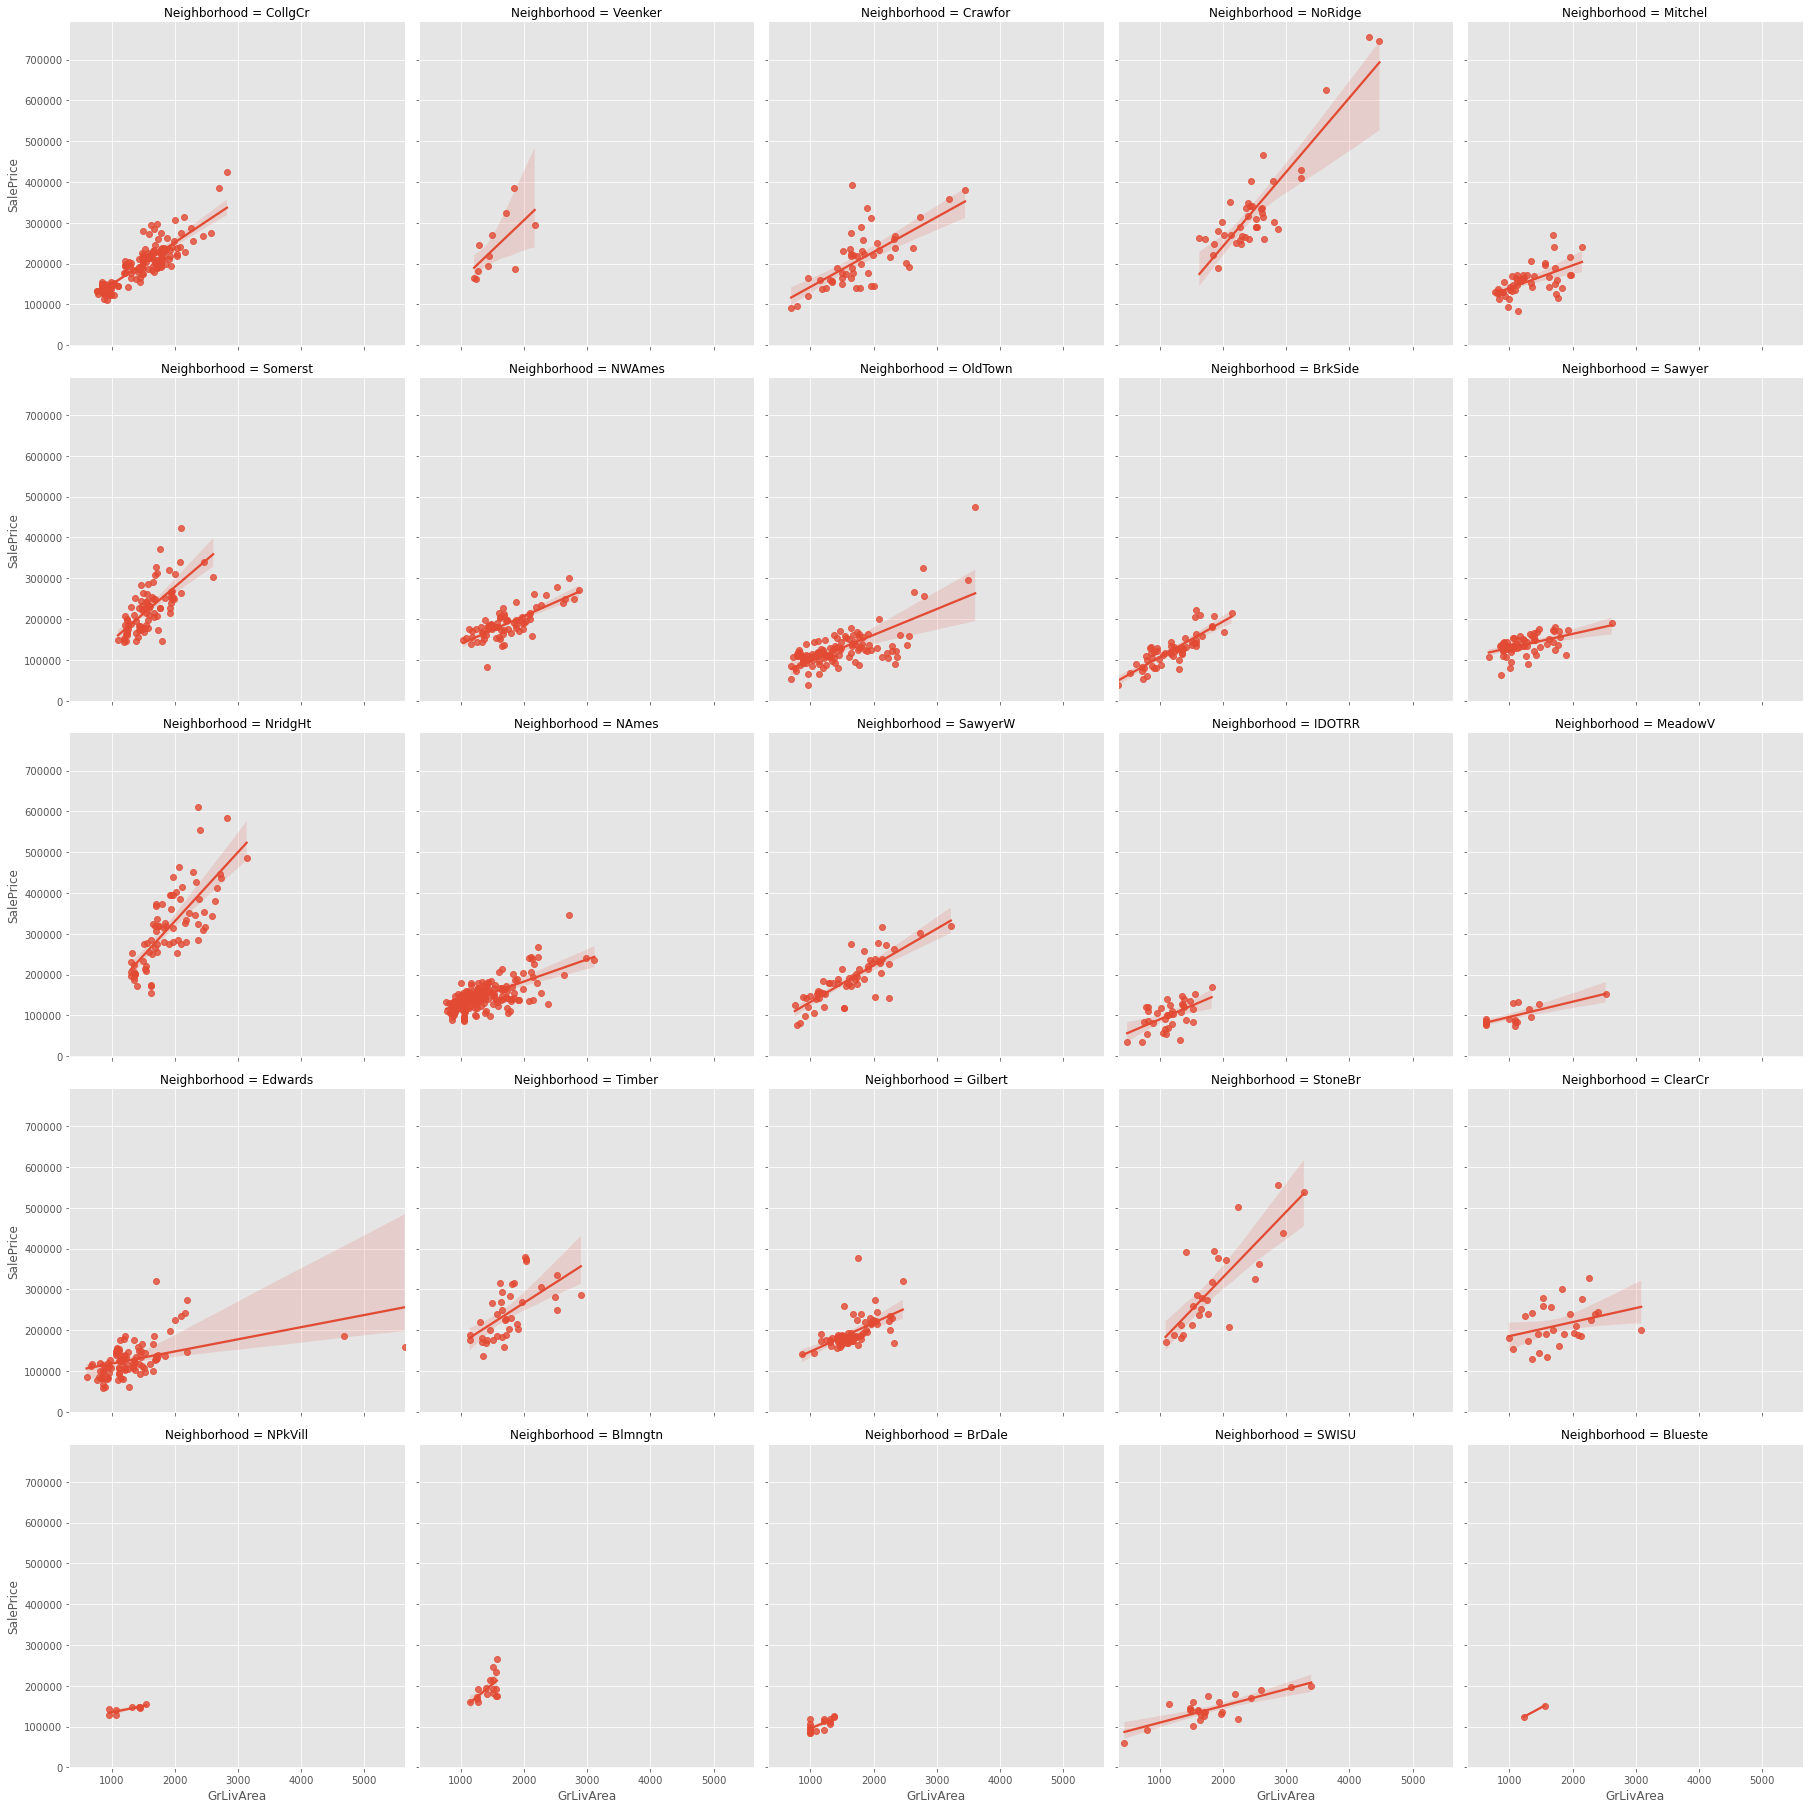

In [415]:
temp = X_temp.join(y)

sns.lmplot(data = temp, x = 'GrLivArea', y = 'SalePrice', col = 'Neighborhood', col_wrap  = 5)

In [416]:
from sklearn.linear_model import LinearRegression

X_groupby = X_temp.join(y).groupby('Neighborhood', group_keys=False).apply(
    lambda x: pd.Series(LinearRegression().fit(x[['GrLivArea']], x['SalePrice']).predict(x[['GrLivArea']]), index  = x.index)
)
X_groupby

Id
220     172221.353604
230     210864.011512
386     174864.662451
444     173480.072103
466     193116.080681
            ...      
765     232038.106363
850     285311.372561
1156    223626.538016
1165    222888.681144
1254    331353.641408
Length: 1460, dtype: float64

In [417]:
test_new(X_groupby)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.040102,-0.001708,0.134013,-0.014856,-0.003658,0.006498
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.099994,-0.004828,0.148065,-0.031933,-0.008058,0.003230
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008454,-0.001184,0.139779,-0.012702,-0.007211,0.004160


### 8.3.3 Feature of "Price/square feet" group by differnt features

In [418]:
X_price_per_squarefeet_by_neighbor = X_temp.join(y).assign(dollar_sq=(y/X_temp['GrLivArea'])).groupby('Neighborhood')['dollar_sq'].transform('mean')
X_price_per_squarefeet_by_neighbor

Id
1       136.783680
2       154.980914
3       136.783680
4       120.254826
5       132.271687
           ...    
1456    119.114931
1457    111.848349
1458    120.254826
1459    116.089385
1460    101.832958
Name: dollar_sq, Length: 1460, dtype: float64

In [419]:
test_new(X_price_per_squarefeet_by_neighbor)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.040961,-0.002094,0.136619,-0.017656,-0.001052,0.003698
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103200,-0.005895,0.155967,-0.034739,-0.000155,0.000424
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008642,-0.000674,0.146297,-0.018469,-0.000693,-0.001607


* This new feature is very effective to imporve prediction

In [420]:
X_price_per_squarefeet_by_MS = X_temp.join(y).assign(dollar_sq=(y/X_temp['GrLivArea'])).groupby('MSSubClass')['dollar_sq'].transform('mean')
X_price_per_squarefeet_by_MS

Id
1       118.371161
2       135.542079
3       118.371161
4        93.051130
5       118.371161
           ...    
1456    118.371161
1457    135.542079
1458     93.051130
1459    135.542079
1460    135.542079
Name: dollar_sq, Length: 1460, dtype: float64

In [421]:
test_new(X_price_per_squarefeet_by_MS)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042342,-0.002444,0.138527,-0.020416,8.565014e-04,0.000938
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103201,-0.005895,0.156122,-0.035151,-4.681674e-07,0.000012
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008483,-0.001235,0.145543,-0.015793,-1.447378e-03,0.001069


In [422]:
test_new(X_price_per_squarefeet_by_neighbor, X_price_per_squarefeet_by_MS)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.040563,-0.001895,0.136630,-0.019195,-0.001041,0.002158
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103200,-0.005895,0.155963,-0.034726,-0.000159,0.000437
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008789,-0.001347,0.146819,-0.020510,-0.000171,-0.003647


### 8.3.4 Combine various quality features (pool, basement, fence, fireplace)

In [423]:
(X_temp[["BsmtQual", "FireplaceQu", "PoolQC", 'Fence', ]] != 0).astype(int).sum(axis = 1)

Id
1       2
2       3
3       3
4       3
5       3
       ..
1456    3
1457    3
1458    3
1459    2
1460    2
Length: 1460, dtype: int64

In [424]:
test_new(
    (X_temp[["BsmtQual", "FireplaceQu", "PoolQC", 'Fence', 'OverallQual']] != 0).astype(int).sum(axis = 1)
)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042143,-0.002458,0.136834,-0.020501,-0.000836,0.000853
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.103174,-0.005905,0.156353,-0.035216,0.000231,-0.000054
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008494,-0.001180,0.146613,-0.017294,-0.000377,-0.000432


# 9. Outliers

### 9.1 Outliers in features

In [425]:
def find_outlier(X):
    num_df = X[area_col]
    Q1 = num_df.quantile(0.25)
    Q3 = num_df.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (num_df < Q1 - 1.5*IQR) | (num_df < Q3 + 1.5*IQR)
    return outliers
    

In [426]:
X_temp_area = X_temp.copy()
X_temp_area[area_col] = X_temp[area_col].apply(lambda x: np.sqrt(x+1))

In [2]:
# is_outliers = find_outlier(X_temp_area).style

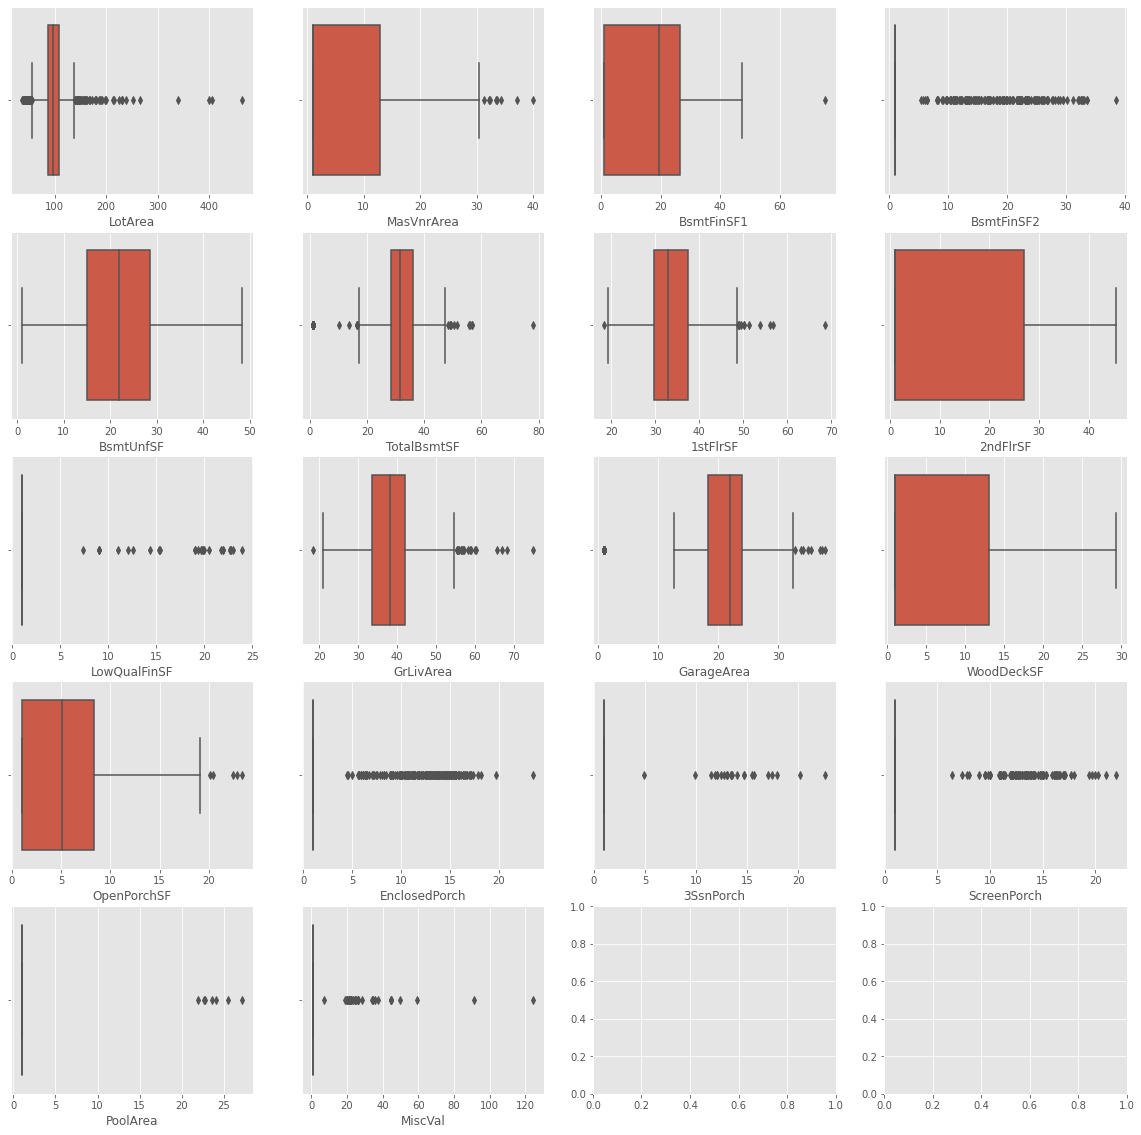

In [428]:
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flat

for i, c in enumerate(area_col):
    sns.boxplot(x=X_temp_area[c],
                ax=axs[i])

* It is easy to see that even after the transfromation to area_related features, there are still many outlier points. So we can't drop any outliers in features.

### 9.2 Outliers in target

In [534]:
y_pred = pd.Series(LinearRegression().fit(X_proc, y_proc).predict(X_proc), index = X_proc.index)
y_pred

Id
1       12.232874
2       12.206889
3       12.260778
4       12.095184
5       12.601165
          ...    
1456    12.061995
1457    12.234452
1458    12.601314
1459    11.914467
1460    11.870759
Length: 1460, dtype: float64

Id
1       False
2       False
3       False
4       False
5       False
        ...  
1456    False
1457    False
1458    False
1459    False
1460    False
Name: is_outlier, Length: 1460, dtype: bool


<AxesSubplot:xlabel='SalePrice'>

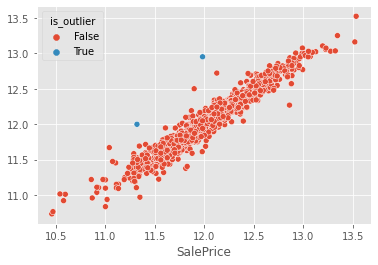

In [535]:
residue = y_proc - y_pred
outliers_y = ((residue - residue.mean())/residue.std()).abs() > 6
outliers_y = outliers_y.rename('is_outlier')
print(outliers_y)
sns.scatterplot(x = y_proc, y = y_pred, hue = outliers_y)

In [536]:
test_new(outliers_y)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.042291,-0.002182,0.139030,-0.021582,0.001360,-0.000228
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.095165,-0.003363,0.133022,-0.021423,-0.023100,0.013740
XGB,0.008384,-0.000989,0.146990,-0.016862,0.009202,-0.001326,0.144881,-0.015492,-0.002109,0.001370


In [537]:
outliers_y[outliers_y].index

Int64Index([633, 1299], dtype='int64', name='Id')

In [433]:
test_new(X=X_proc.drop(index=outliers_y[outliers_y].index, errors='ignore'), y=y_proc.drop(index=outliers_y[outliers_y].index, errors='ignore'))

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.037320,-0.001100,0.122280,-0.006474,-0.015391,0.014879
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.087396,-0.001173,0.113530,-0.008031,-0.042593,0.027131
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008349,-0.000622,0.130429,-0.011207,-0.016561,0.005655


* It is very useful by dropping several outliers

# 9. Putting all together

In [538]:
def all_features(train, test, train_before_encoding, y):
    
    corr_num = (X_corr_num.where(lambda x: x.abs() > 0.5).dropna(thresh=4, axis = 0).index).to_list()

    def PCA_trans(train, test, selected_cols = None):
        if selected_cols:
            train = train[selected_cols]
            test = test[selected_cols]
            
        cat_cols_train = train.select_dtypes("category").columns
        train[cat_cols_train] = train[cat_cols_train].apply(lambda x: x.cat.codes)
        cat_cols_test= test.select_dtypes("category").columns
        test[cat_cols_test] = test[cat_cols_test].apply(lambda x: x.cat.codes)        


        scaler = preprocessing.StandardScaler().fit(train)
        train_scaled = scaler.transform(train)
        test_scaled = scaler.transform(test)

        pca = PCA(n_components=0.8).fit(train_scaled)
        PCA_train = pd.DataFrame(pca.transform(train_scaled), index = train.index)
        PCA_test = pd.DataFrame(pca.transform(test_scaled), index = test.index)

        return PCA_train[0], PCA_test[0]
    
    PCA_train, PCA_test = PCA_trans(train, test)
    PCA_train_corr, PCA_test_corr = PCA_trans(train, test, selected_cols = corr_num)
    
    # area transformation
    train[area_col] = train[area_col].apply(lambda x: np.sqrt(x+1))
    test[area_col] = test[area_col].apply(lambda x: np.sqrt(x+1))
    
    # dolloar per square feet feature
    dic = (X_temp.join(y).assign(dollar_sq=(y/X_temp['GrLivArea'])).groupby('Neighborhood')['dollar_sq'].agg('mean')).to_dict()
    train_dollar_sq = X['Neighborhood'].map(dic)
    train_dollar_sq = train_dollar_sq.rename('dollar_sq')
    test_dollar_sq = X_test['Neighborhood'].map(dic) 
    test_dollar_sq = test_dollar_sq.rename('dollar_sq')
    
    
    # new features
    def new_features(X):
        features = [X.eval('(GrLivArea + TotalBsmtSF) / (TotRmsAbvGrd + FullBath + HalfBath)'),
                    X.eval('OverallQual * OverallCond')
#                     ,X.eval(X.groupby('Neighborhood')['GrLivArea'].transform('mean'))
                   ]
    
        return features
    
    # only keep high influenced features
    s_mi_train = mutual_info(X_proc, y_proc)
    train = train.loc[:, s_mi_train > 1e-4]
    test = test.loc[:, s_mi_train > 1e-4]
    
    new_feature_train = new_features(train)
    new_feature_train.extend([PCA_train, PCA_train_corr, train_dollar_sq])
    train = train.join(s.rename(f'new_{i}') for i, s in enumerate(new_feature_train))

    
    new_feature_test = new_features(test)
    new_feature_test.extend([PCA_test, PCA_test_corr, test_dollar_sq])
    test = test.join(s.rename(f'new_{i}') for i, s in enumerate(new_feature_test))
    
    return train, test

In [539]:
train, test = all_features(X_proc, X_test_proc, X_temp, y_proc)

In [540]:
# test the effect of dropping outlier points
train = train.loc[~outliers_y, :]
y_proc = y_proc.loc[~outliers_y]

In [541]:
test_new(X=train, y=y_proc)

,base-mean_train_score,base-std_train_score,base-mean_test_score,base-std_test_score,new-mean_train_score,new-std_train_score,new-mean_test_score,new-std_test_score,mean_diff,std_diff
LGB,0.042202,-0.002408,0.137671,-0.021353,0.040987,-0.001833,0.127748,-0.009969,-0.009923,0.011384
Ridge,0.103202,-0.005896,0.156122,-0.035163,0.094162,-0.002058,0.117785,-0.012010,-0.038337,0.023153
XGB,0.008384,-0.000989,0.146990,-0.016862,0.008024,-0.000465,0.137004,-0.007892,-0.009986,0.008970


# 10. Models

In [542]:
from sklearn.linear_model import ElasticNetCV, Lasso, Ridge, RidgeCV

In [559]:
models_dict = {
    "LGBM": lgb.LGBMRegressor(objective="rmse", random_state=random_state),
    "XGB": xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=random_state),
    "SVR": SVR(),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(max_iter=10_000, random_state=random_state), 
    "Ridge": Ridge(alpha=10)}

model_score = {}
for name, model in models_dict.items():
    r = cross_val_score(model, train, y_proc, cv = get_folds(train, y_proc), scoring='neg_root_mean_squared_error')
    model_score[name] = -r.mean()
    
pd.Series(model_score).sort_values()

Ridge         0.115154
Lasso         0.116016
LGBM          0.127748
XGB           0.137004
ElasticNet    0.172048
SVR           0.292414
dtype: float64

In [544]:
train_final, test_final = train.align(test, join ='inner', axis=1)

In [545]:
train_final.shape

(1458, 188)

In [547]:
model = Ridge()
model = model.fit(train_final, y_proc)
predict = np.exp(model.predict(test_final))
df_predict = pd.DataFrame({'Id': test_final.index, 'SalePrice': predict})
df_predict.to_csv('new_2.csv', encoding='utf8', index=False)